In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim

# 读取数据

In [2]:
file_dir = "/l1/data/FBDQA2021A_MMP_Challenge_ver0.2/data"

sym = 4
dates = list(range(24))
df = pd.DataFrame()
for date in dates:
    if (date & 1):
        file_name = f"snapshot_sym{sym}_date{date//2}_am.csv"
    else:
        file_name = f"snapshot_sym{sym}_date{date//2}_pm.csv"
    if not os.path.isfile(os.path.join(file_dir,file_name)):
        continue
    new_df = pd.read_csv(os.path.join(file_dir,file_name))
    # 价格+1（从涨跌幅还原到对前收盘价的比例）
    new_df['bid1'] = new_df['n_bid1']+1
    new_df['bid2'] = new_df['n_bid2']+1
    new_df['bid3'] = new_df['n_bid3']+1
    new_df['bid4'] = new_df['n_bid4']+1
    new_df['bid5'] = new_df['n_bid5']+1
    new_df['ask1'] = new_df['n_ask1']+1
    new_df['ask2'] = new_df['n_ask2']+1
    new_df['ask3'] = new_df['n_ask3']+1
    new_df['ask4'] = new_df['n_ask4']+1
    new_df['ask5'] = new_df['n_ask5']+1
    
    # 量价组合
    new_df['spread1'] =  new_df['ask1'] - new_df['bid1']
    new_df['spread2'] =  new_df['ask2'] - new_df['bid2']
    new_df['spread3'] =  new_df['ask3'] - new_df['bid3']
    new_df['mid_price1'] =  new_df['ask1'] + new_df['bid1']
    new_df['mid_price2'] =  new_df['ask2'] + new_df['bid2']
    new_df['mid_price3'] =  new_df['ask3'] + new_df['bid3']
    new_df['weighted_ab1'] = (new_df['ask1'] * new_df['n_bsize1'] + new_df['bid1'] * new_df['n_asize1']) / (new_df['n_bsize1'] + new_df['n_asize1'])
    new_df['weighted_ab2'] = (new_df['ask2'] * new_df['n_bsize2'] + new_df['bid2'] * new_df['n_asize2']) / (new_df['n_bsize2'] + new_df['n_asize2'])
    new_df['weighted_ab3'] = (new_df['ask3'] * new_df['n_bsize3'] + new_df['bid3'] * new_df['n_asize3']) / (new_df['n_bsize3'] + new_df['n_asize3'])
    
    new_df['vol1_rel_diff']   = (new_df['n_bsize1'] - new_df['n_asize1']) / (new_df['n_bsize1'] + new_df['n_asize1'])
    new_df['volall_rel_diff'] = (new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] \
                     - new_df['n_asize1'] - new_df['n_asize2'] - new_df['n_asize3'] - new_df['n_asize4'] - new_df['n_asize5'] ) / \
                     ( new_df['n_bsize1'] + new_df['n_bsize2'] + new_df['n_bsize3'] + new_df['n_bsize4'] + new_df['n_bsize5'] \
                     + new_df['n_asize1'] + new_df['n_asize2'] + new_df['n_asize3'] + new_df['n_asize4'] + new_df['n_asize5'] )
                            
    new_df['amount'] = new_df['amount_delta'].map(np.log1p)
    df = df.append(new_df)
    




In [3]:
df

,date,time,sym,n_close,amount_delta,n_midprice,n_bid1,n_bsize1,n_bid2,n_bsize2,...,spread3,mid_price1,mid_price2,mid_price3,weighted_ab1,weighted_ab2,weighted_ab3,vol1_rel_diff,volall_rel_diff,amount
0,0,13:10:03,4,-0.014876,25032.0,-0.015289,-0.015702,2.584610e-05,-0.016529,0.000081,...,0.004132,1.969421,1.969421,1.969421,0.984760,0.985554,0.986383,0.118386,0.626549,10.127950
1,0,13:10:06,4,-0.014876,0.0,-0.015289,-0.015702,2.584610e-05,-0.016529,0.000081,...,0.004132,1.969421,1.969421,1.969421,0.984808,0.985554,0.986383,0.235822,0.650704,0.000000
2,0,13:10:09,4,-0.015702,1669544.0,-0.016116,-0.016529,8.080050e-05,-0.017355,0.000031,...,0.004132,1.967769,1.967769,1.967769,0.984194,0.984272,0.985212,0.749770,0.675229,14.328062
3,0,13:10:12,4,-0.016529,21420.0,-0.016116,-0.016529,8.054896e-05,-0.017355,0.000031,...,0.004132,1.967769,1.967769,1.967769,0.984194,0.984272,0.985212,0.749086,0.669201,9.972127
4,0,13:10:15,4,-0.016529,0.0,-0.016116,-0.016529,8.056831e-05,-0.017355,0.000031,...,0.004132,1.967769,1.967769,1.967769,0.984194,0.984272,0.985217,0.749139,0.669819,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,11,11:19:45,4,-0.004680,1665200.0,-0.003900,-0.004680,1.613688e-05,-0.005460,0.000010,...,0.004680,1.992200,1.992200,1.992200,0.996736,0.995265,0.994582,0.815016,-0.332393,14.325456
1995,11,11:19:48,4,-0.004680,66353.0,-0.003900,-0.004680,1.524684e-05,-0.005460,0.000010,...,0.004680,1.992200,1.992200,1.992200,0.996692,0.995263,0.994582,0.758929,-0.340953,11.102759
1996,11,11:19:51,4,-0.004680,0.0,-0.003900,-0.004680,1.495661e-05,-0.005460,0.000011,...,0.004680,1.992200,1.992200,1.992200,0.996754,0.995279,0.994582,0.838288,-0.338120,0.000000
1997,11,11:19:54,4,-0.003120,28114.0,-0.003510,-0.003900,6.385097e-07,-0.004680,0.000001,...,0.003900,1.992980,1.992980,1.992980,0.996153,0.995398,0.995311,-0.862786,-0.574108,10.244059


In [13]:
feature_col_names = ['bid1','n_bsize1',
                     'bid2','n_bsize2',
                     'bid3','n_bsize3',
                     'bid4','n_bsize4',
                     'bid5','n_bsize5',
                     'ask1','n_asize1',
                     'ask2','n_asize2',
                     'ask3','n_asize3',
                     'ask4','n_asize4',
                     'ask5','n_asize5',
                     'spread1','mid_price1',
                     'spread2','mid_price2',
                     'spread3','mid_price3',
                     'weighted_ab1','weighted_ab2','weighted_ab3','amount',
                     'vol1_rel_diff','volall_rel_diff'
                    ]
label_col_name = ['label_5']

In [14]:
n = len(df)
##划分训练/测试集
train_nums = int(n*0.8)
val_nums = int(n*0.1)
print(f'train_nums: {train_nums}, val_nums: {val_nums}, test_nums: {n-train_nums-val_nums}')
train_data = np.ascontiguousarray(df[feature_col_names][:train_nums].values)
train_label = df[label_col_name][:train_nums].values.reshape(-1)

val_data = np.ascontiguousarray(df[feature_col_names][train_nums:train_nums+val_nums].values)
val_label = df[label_col_name][train_nums:train_nums+val_nums].values.reshape(-1)

test_data = np.ascontiguousarray(df[feature_col_names][train_nums+val_nums:].values)
test_label = df[label_col_name][train_nums+val_nums:].values.reshape(-1)

train_nums: 38380, val_nums: 4797, test_nums: 4799


## GPU准备

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 准备dataset

In [16]:
def data_transform(X, T):
    [N, D] = X.shape
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = X[i - T:i, :]
    return dataX

In [17]:
class Dataset(data.Dataset):
    def __init__(self, data, label,  num_classes, T):
        self.T = T

        data = data_transform(data, self.T)

        self.x = torch.tensor(data).to(torch.float32).unsqueeze(1).to(device)

#         self.y = F.one_hot(torch.tensor(label[T - 1:].astype(np.int64)), num_classes=3)
        self.y = torch.tensor(label[T - 1:].astype(np.int64)).to(device)
    
        self.length = len(self.x)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [18]:
batch_size = 512

dataset_train = Dataset(data=train_data,label=train_label, num_classes=3, T=100)
dataset_val   = Dataset(data=val_data,  label=val_label,   num_classes=3, T=100)
dataset_test  = Dataset(data=test_data, label=test_label,  num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape, dataset_train.x.requires_grad, dataset_train.y.requires_grad,)
print(dataset_val.x.shape, dataset_val.y.shape, dataset_val.x.requires_grad, dataset_val.y.requires_grad,)
print(dataset_test.x.shape, dataset_test.y.shape, dataset_test.x.requires_grad, dataset_test.y.requires_grad,)

torch.Size([38281, 1, 100, 32]) torch.Size([38281]) False False
torch.Size([4698, 1, 100, 32]) torch.Size([4698]) False False
torch.Size([4700, 1, 100, 32]) torch.Size([4700]) False False


In [19]:
print(dataset_train.x.device)
print(dataset_train.y.device)

cpu
cpu


# 定义模型

In [20]:
class deeplob(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,1),stride=(2,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1),stride=(2,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,8)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1),stride=(2,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(16),
        )
       
        # lstm layers
        self.fc = nn.Sequential(nn.Linear(384, 64),nn.Linear(64, self.num_classes))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)

        x = x.reshape(-1,48*8)
        x = self.fc(x)

        forecast_y = torch.softmax(x, dim=1)

        return forecast_y

In [21]:
model = deeplob(num_classes = 3)
model.to(device);

In [22]:
summary(model, (1, 1, 100, 32))

Layer (type:depth-idx)                   Output Shape              Param #
deeplob                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 32, 47, 16]           --
│    └─Conv2d: 2-1                       [1, 32, 100, 16]          96
│    └─LeakyReLU: 2-2                    [1, 32, 100, 16]          --
│    └─BatchNorm2d: 2-3                  [1, 32, 100, 16]          64
│    └─Conv2d: 2-4                       [1, 32, 97, 16]           4,128
│    └─LeakyReLU: 2-5                    [1, 32, 97, 16]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 97, 16]           64
│    └─Conv2d: 2-7                       [1, 32, 47, 16]           5,152
│    └─LeakyReLU: 2-8                    [1, 32, 47, 16]           --
│    └─BatchNorm2d: 2-9                  [1, 32, 47, 16]           64
├─Sequential: 1-2                        [1, 32, 21, 8]            --
│    └─Conv2d: 2-10                      [1, 32, 47, 8]            2,080
│    └

# 训练模型

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 1e-5)

In [24]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0

    for it in tqdm(range(epochs)):
        if ((epochs+1) % 10 == 0):
            optimizer.lr = optimizer.lr*0.5
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)

            loss = criterion(outputs, targets)

            loss.backward()
            
            optimizer.step()
            
            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        if test_loss < best_test_loss:
            torch.save(model, f'best_val_model_pytorch_sym{sym}_date{dates[-1]}')
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
    torch.save(model, f'final_model_pytorch_sym{sym}_date{dates[-1]}')
    return train_losses, test_losses

In [25]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=50)

  2%|▏         | 1/50 [00:19<15:54, 19.49s/it]

model saved
Epoch 1/50, Train Loss: 1.0991,           Validation Loss: 1.0397, Duration: 0:00:19.486250, Best Val Epoch: 0


  4%|▍         | 2/50 [00:37<15:17, 19.12s/it]

model saved
Epoch 2/50, Train Loss: 1.0579,           Validation Loss: 0.9765, Duration: 0:00:18.274715, Best Val Epoch: 1


  6%|▌         | 3/50 [00:56<14:56, 19.08s/it]

model saved
Epoch 3/50, Train Loss: 1.0172,           Validation Loss: 0.9433, Duration: 0:00:18.965799, Best Val Epoch: 2


  8%|▊         | 4/50 [01:15<14:28, 18.89s/it]

model saved
Epoch 4/50, Train Loss: 0.9839,           Validation Loss: 0.9387, Duration: 0:00:18.451146, Best Val Epoch: 3


 10%|█         | 5/50 [01:33<14:02, 18.73s/it]

Epoch 5/50, Train Loss: 0.9648,           Validation Loss: 0.9437, Duration: 0:00:18.345793, Best Val Epoch: 3


 12%|█▏        | 6/50 [01:51<13:39, 18.62s/it]

model saved
Epoch 6/50, Train Loss: 0.9531,           Validation Loss: 0.9302, Duration: 0:00:18.366881, Best Val Epoch: 5


 14%|█▍        | 7/50 [02:10<13:15, 18.50s/it]

model saved
Epoch 7/50, Train Loss: 0.9462,           Validation Loss: 0.9197, Duration: 0:00:18.231379, Best Val Epoch: 6


 16%|█▌        | 8/50 [02:29<13:08, 18.78s/it]

Epoch 8/50, Train Loss: 0.9423,           Validation Loss: 0.9200, Duration: 0:00:19.437840, Best Val Epoch: 6


 18%|█▊        | 9/50 [02:48<12:50, 18.79s/it]

Epoch 9/50, Train Loss: 0.9389,           Validation Loss: 0.9251, Duration: 0:00:18.797607, Best Val Epoch: 6


 20%|██        | 10/50 [03:07<12:36, 18.91s/it]

Epoch 10/50, Train Loss: 0.9370,           Validation Loss: 0.9261, Duration: 0:00:19.178028, Best Val Epoch: 6


 22%|██▏       | 11/50 [03:26<12:19, 18.95s/it]

Epoch 11/50, Train Loss: 0.9351,           Validation Loss: 0.9241, Duration: 0:00:19.052775, Best Val Epoch: 6


 24%|██▍       | 12/50 [03:45<12:00, 18.97s/it]

model saved
Epoch 12/50, Train Loss: 0.9340,           Validation Loss: 0.9151, Duration: 0:00:19.010028, Best Val Epoch: 11


 26%|██▌       | 13/50 [04:04<11:42, 18.98s/it]

Epoch 13/50, Train Loss: 0.9320,           Validation Loss: 0.9155, Duration: 0:00:18.995261, Best Val Epoch: 11


 28%|██▊       | 14/50 [04:23<11:25, 19.04s/it]

Epoch 14/50, Train Loss: 0.9305,           Validation Loss: 0.9557, Duration: 0:00:19.184055, Best Val Epoch: 11


 30%|███       | 15/50 [04:42<11:05, 19.02s/it]

Epoch 15/50, Train Loss: 0.9292,           Validation Loss: 0.9209, Duration: 0:00:18.961598, Best Val Epoch: 11


 32%|███▏      | 16/50 [05:01<10:40, 18.85s/it]

Epoch 16/50, Train Loss: 0.9283,           Validation Loss: 0.9190, Duration: 0:00:18.455443, Best Val Epoch: 11


 34%|███▍      | 17/50 [05:19<10:17, 18.71s/it]

Epoch 17/50, Train Loss: 0.9274,           Validation Loss: 0.9190, Duration: 0:00:18.400862, Best Val Epoch: 11


 36%|███▌      | 18/50 [05:38<09:58, 18.70s/it]

model saved
Epoch 18/50, Train Loss: 0.9266,           Validation Loss: 0.9137, Duration: 0:00:18.663370, Best Val Epoch: 17


 38%|███▊      | 19/50 [05:56<09:38, 18.65s/it]

Epoch 19/50, Train Loss: 0.9254,           Validation Loss: 0.9448, Duration: 0:00:18.530510, Best Val Epoch: 17


 40%|████      | 20/50 [06:15<09:24, 18.80s/it]

Epoch 20/50, Train Loss: 0.9243,           Validation Loss: 0.9615, Duration: 0:00:19.153060, Best Val Epoch: 17


 42%|████▏     | 21/50 [06:35<09:10, 18.98s/it]

Epoch 21/50, Train Loss: 0.9240,           Validation Loss: 0.9402, Duration: 0:00:19.405647, Best Val Epoch: 17


 44%|████▍     | 22/50 [06:54<08:53, 19.04s/it]

model saved
Epoch 22/50, Train Loss: 0.9220,           Validation Loss: 0.9118, Duration: 0:00:19.161750, Best Val Epoch: 21


 46%|████▌     | 23/50 [07:13<08:32, 18.98s/it]

Epoch 23/50, Train Loss: 0.9216,           Validation Loss: 0.9149, Duration: 0:00:18.837283, Best Val Epoch: 21


 48%|████▊     | 24/50 [07:32<08:15, 19.04s/it]

Epoch 24/50, Train Loss: 0.9208,           Validation Loss: 0.9158, Duration: 0:00:19.183726, Best Val Epoch: 21


 50%|█████     | 25/50 [07:52<07:59, 19.18s/it]

Epoch 25/50, Train Loss: 0.9201,           Validation Loss: 0.9166, Duration: 0:00:19.504451, Best Val Epoch: 21


 52%|█████▏    | 26/50 [08:10<07:37, 19.07s/it]

Epoch 26/50, Train Loss: 0.9198,           Validation Loss: 0.9686, Duration: 0:00:18.823918, Best Val Epoch: 21


 54%|█████▍    | 27/50 [08:29<07:16, 18.98s/it]

Epoch 27/50, Train Loss: 0.9187,           Validation Loss: 0.9163, Duration: 0:00:18.768142, Best Val Epoch: 21


 56%|█████▌    | 28/50 [08:47<06:53, 18.78s/it]

Epoch 28/50, Train Loss: 0.9175,           Validation Loss: 0.9212, Duration: 0:00:18.318716, Best Val Epoch: 21


 58%|█████▊    | 29/50 [09:06<06:33, 18.76s/it]

Epoch 29/50, Train Loss: 0.9169,           Validation Loss: 0.9231, Duration: 0:00:18.707510, Best Val Epoch: 21


 60%|██████    | 30/50 [09:25<06:16, 18.83s/it]

Epoch 30/50, Train Loss: 0.9161,           Validation Loss: 0.9254, Duration: 0:00:18.999675, Best Val Epoch: 21


 62%|██████▏   | 31/50 [09:44<05:57, 18.80s/it]

Epoch 31/50, Train Loss: 0.9159,           Validation Loss: 0.9144, Duration: 0:00:18.720284, Best Val Epoch: 21


 64%|██████▍   | 32/50 [10:03<05:38, 18.83s/it]

Epoch 32/50, Train Loss: 0.9149,           Validation Loss: 0.9800, Duration: 0:00:18.881718, Best Val Epoch: 21


 66%|██████▌   | 33/50 [10:22<05:21, 18.89s/it]

Epoch 33/50, Train Loss: 0.9140,           Validation Loss: 0.9119, Duration: 0:00:19.056371, Best Val Epoch: 21


 68%|██████▊   | 34/50 [10:41<05:02, 18.93s/it]

Epoch 34/50, Train Loss: 0.9133,           Validation Loss: 0.9138, Duration: 0:00:19.009644, Best Val Epoch: 21


 70%|███████   | 35/50 [10:59<04:41, 18.78s/it]

Epoch 35/50, Train Loss: 0.9127,           Validation Loss: 0.9285, Duration: 0:00:18.414362, Best Val Epoch: 21


 72%|███████▏  | 36/50 [11:17<04:18, 18.48s/it]

Epoch 36/50, Train Loss: 0.9114,           Validation Loss: 0.9195, Duration: 0:00:17.805652, Best Val Epoch: 21


 74%|███████▍  | 37/50 [11:35<03:59, 18.43s/it]

Epoch 37/50, Train Loss: 0.9113,           Validation Loss: 0.9288, Duration: 0:00:18.296912, Best Val Epoch: 21


 76%|███████▌  | 38/50 [11:54<03:42, 18.51s/it]

Epoch 38/50, Train Loss: 0.9106,           Validation Loss: 0.9241, Duration: 0:00:18.690577, Best Val Epoch: 21


 78%|███████▊  | 39/50 [12:13<03:24, 18.56s/it]

Epoch 39/50, Train Loss: 0.9099,           Validation Loss: 1.0004, Duration: 0:00:18.678362, Best Val Epoch: 21


 80%|████████  | 40/50 [12:31<03:06, 18.61s/it]

Epoch 40/50, Train Loss: 0.9094,           Validation Loss: 0.9267, Duration: 0:00:18.725329, Best Val Epoch: 21


 82%|████████▏ | 41/50 [12:50<02:47, 18.64s/it]

Epoch 41/50, Train Loss: 0.9076,           Validation Loss: 0.9577, Duration: 0:00:18.718194, Best Val Epoch: 21


 84%|████████▍ | 42/50 [13:09<02:29, 18.67s/it]

Epoch 42/50, Train Loss: 0.9064,           Validation Loss: 0.9155, Duration: 0:00:18.718597, Best Val Epoch: 21


 86%|████████▌ | 43/50 [13:28<02:11, 18.71s/it]

Epoch 43/50, Train Loss: 0.9056,           Validation Loss: 0.9637, Duration: 0:00:18.825243, Best Val Epoch: 21


 88%|████████▊ | 44/50 [13:47<01:52, 18.75s/it]

Epoch 44/50, Train Loss: 0.9048,           Validation Loss: 0.9198, Duration: 0:00:18.825488, Best Val Epoch: 21


 90%|█████████ | 45/50 [14:06<01:34, 18.85s/it]

Epoch 45/50, Train Loss: 0.9041,           Validation Loss: 0.9458, Duration: 0:00:19.073992, Best Val Epoch: 21


 92%|█████████▏| 46/50 [14:25<01:15, 18.87s/it]

Epoch 46/50, Train Loss: 0.9042,           Validation Loss: 0.9247, Duration: 0:00:18.925532, Best Val Epoch: 21


 94%|█████████▍| 47/50 [14:44<00:56, 18.90s/it]

Epoch 47/50, Train Loss: 0.9022,           Validation Loss: 0.9140, Duration: 0:00:18.969970, Best Val Epoch: 21


 96%|█████████▌| 48/50 [15:03<00:37, 18.95s/it]

Epoch 48/50, Train Loss: 0.9021,           Validation Loss: 0.9145, Duration: 0:00:19.076923, Best Val Epoch: 21


 98%|█████████▊| 49/50 [15:22<00:18, 18.98s/it]

Epoch 49/50, Train Loss: 0.9005,           Validation Loss: 0.9332, Duration: 0:00:19.029551, Best Val Epoch: 21


100%|██████████| 50/50 [15:40<00:00, 18.82s/it]

Epoch 50/50, Train Loss: 0.9006,           Validation Loss: 0.9295, Duration: 0:00:18.694381, Best Val Epoch: 21


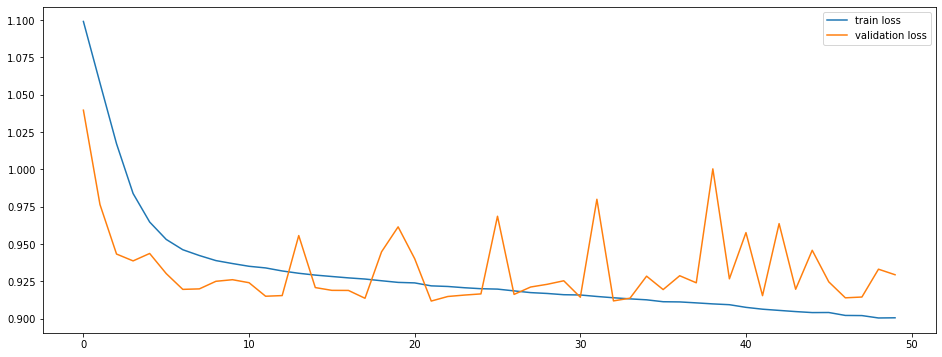

In [26]:
plt.figure(figsize=(16,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

# 测试模型

In [27]:
model = torch.load(f'best_val_model_pytorch_sym{sym}_date{dates[-1]}', map_location=device)
model.eval()
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.7065957446808511
              precision    recall  f1-score   support

           0     0.5000    0.0013    0.0027       742
           1     0.7067    1.0000    0.8281      3320
           2     0.0000    0.0000    0.0000       638

    accuracy                         0.7066      4700
   macro avg     0.4022    0.3338    0.2769      4700
weighted avg     0.5781    0.7066    0.5854      4700



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# model = torch.load('best_val_model_pytorch',map_location=device)
all_targets = []
all_predictions = []

for inputs, targets in train_loader:

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions) 
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.6156840207936052
              precision    recall  f1-score   support

           0     0.3864    0.0657    0.1123      7350
           1     0.6449    0.9354    0.7635     23831
           2     0.3221    0.1118    0.1660      7100

    accuracy                         0.6157     38281
   macro avg     0.4511    0.3710    0.3473     38281
weighted avg     0.5354    0.6157    0.5276     38281



# 过拟合：小规模数据难以充分训练大模型

In [29]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(3200,128),
                    nn.LeakyReLU(),
                    nn.Linear(128,64),
                    nn.LeakyReLU(),
                    nn.Linear(64,64),
                    nn.LeakyReLU(),
                    nn.Linear(64,3)
                )
        
    def forward(self,x):
        x = x.view(-1,100*32)
        x = self.net(x)
        return torch.softmax(x, dim=1)

In [30]:
model = MLP()
model.to(device)
summary(model,(1,1,100,32))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 3]                    --
├─Sequential: 1-1                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 128]                  409,728
│    └─LeakyReLU: 2-2                    [1, 128]                  --
│    └─Linear: 2-3                       [1, 64]                   8,256
│    └─LeakyReLU: 2-4                    [1, 64]                   --
│    └─Linear: 2-5                       [1, 64]                   4,160
│    └─LeakyReLU: 2-6                    [1, 64]                   --
│    └─Linear: 2-7                       [1, 3]                    195
Total params: 422,339
Trainable params: 422,339
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.69
Estimated Total Size (MB): 1.70

In [31]:
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([2,1,2]).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)#, momentum=0.9, weight_decay = 1e-5)

In [32]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=500)

  0%|          | 1/500 [00:00<05:11,  1.60it/s]

model saved
Epoch 1/500, Train Loss: 1.0631,           Validation Loss: 1.0452, Duration: 0:00:00.624950, Best Val Epoch: 0


  0%|          | 2/500 [00:01<05:03,  1.64it/s]

model saved
Epoch 2/500, Train Loss: 1.0478,           Validation Loss: 1.0405, Duration: 0:00:00.570951, Best Val Epoch: 1


  1%|          | 3/500 [00:01<04:52,  1.70it/s]

model saved
Epoch 3/500, Train Loss: 1.0473,           Validation Loss: 1.0345, Duration: 0:00:00.541252, Best Val Epoch: 2


  1%|          | 4/500 [00:02<04:41,  1.76it/s]

Epoch 4/500, Train Loss: 1.0424,           Validation Loss: 1.0347, Duration: 0:00:00.517870, Best Val Epoch: 2


  1%|          | 5/500 [00:02<04:45,  1.74it/s]

model saved
Epoch 5/500, Train Loss: 1.0359,           Validation Loss: 1.0238, Duration: 0:00:00.594401, Best Val Epoch: 4


  1%|          | 6/500 [00:03<04:34,  1.80it/s]

model saved
Epoch 6/500, Train Loss: 1.0261,           Validation Loss: 1.0150, Duration: 0:00:00.503706, Best Val Epoch: 5


  1%|▏         | 7/500 [00:03<04:35,  1.79it/s]

Epoch 7/500, Train Loss: 1.0121,           Validation Loss: 1.0710, Duration: 0:00:00.567229, Best Val Epoch: 5


  2%|▏         | 8/500 [00:04<04:24,  1.86it/s]

Epoch 8/500, Train Loss: 1.0107,           Validation Loss: 1.0406, Duration: 0:00:00.484532, Best Val Epoch: 5


  2%|▏         | 9/500 [00:04<04:16,  1.92it/s]

model saved
Epoch 9/500, Train Loss: 1.0030,           Validation Loss: 1.0023, Duration: 0:00:00.486770, Best Val Epoch: 8


  2%|▏         | 10/500 [00:05<04:17,  1.90it/s]

model saved
Epoch 10/500, Train Loss: 0.9905,           Validation Loss: 0.9907, Duration: 0:00:00.531981, Best Val Epoch: 9


  2%|▏         | 11/500 [00:05<04:12,  1.94it/s]

Epoch 11/500, Train Loss: 0.9918,           Validation Loss: 0.9975, Duration: 0:00:00.493981, Best Val Epoch: 9


  2%|▏         | 12/500 [00:06<04:05,  1.98it/s]

Epoch 12/500, Train Loss: 0.9923,           Validation Loss: 1.0087, Duration: 0:00:00.474708, Best Val Epoch: 9


  3%|▎         | 13/500 [00:06<04:19,  1.88it/s]

model saved
Epoch 13/500, Train Loss: 0.9846,           Validation Loss: 0.9830, Duration: 0:00:00.596096, Best Val Epoch: 12


  3%|▎         | 14/500 [00:07<04:17,  1.89it/s]

model saved
Epoch 14/500, Train Loss: 0.9761,           Validation Loss: 0.9704, Duration: 0:00:00.525177, Best Val Epoch: 13


  3%|▎         | 15/500 [00:07<04:08,  1.95it/s]

Epoch 15/500, Train Loss: 0.9777,           Validation Loss: 1.0033, Duration: 0:00:00.469856, Best Val Epoch: 13


  3%|▎         | 16/500 [00:08<04:10,  1.93it/s]

Epoch 16/500, Train Loss: 0.9867,           Validation Loss: 0.9736, Duration: 0:00:00.526859, Best Val Epoch: 13


  3%|▎         | 17/500 [00:09<04:08,  1.94it/s]

Epoch 17/500, Train Loss: 0.9815,           Validation Loss: 0.9970, Duration: 0:00:00.508775, Best Val Epoch: 13


  4%|▎         | 18/500 [00:09<04:12,  1.91it/s]

Epoch 18/500, Train Loss: 0.9837,           Validation Loss: 0.9971, Duration: 0:00:00.544697, Best Val Epoch: 13


  4%|▍         | 19/500 [00:10<04:04,  1.97it/s]

Epoch 19/500, Train Loss: 0.9810,           Validation Loss: 0.9787, Duration: 0:00:00.471532, Best Val Epoch: 13


  4%|▍         | 20/500 [00:10<03:57,  2.02it/s]

Epoch 20/500, Train Loss: 0.9786,           Validation Loss: 0.9714, Duration: 0:00:00.461214, Best Val Epoch: 13


  4%|▍         | 21/500 [00:11<04:00,  1.99it/s]

Epoch 21/500, Train Loss: 0.9760,           Validation Loss: 0.9706, Duration: 0:00:00.516065, Best Val Epoch: 13


  4%|▍         | 22/500 [00:11<03:55,  2.03it/s]

model saved
Epoch 22/500, Train Loss: 0.9703,           Validation Loss: 0.9678, Duration: 0:00:00.469458, Best Val Epoch: 21


  5%|▍         | 23/500 [00:11<03:51,  2.06it/s]

Epoch 23/500, Train Loss: 0.9766,           Validation Loss: 0.9846, Duration: 0:00:00.465844, Best Val Epoch: 21


  5%|▍         | 24/500 [00:12<03:55,  2.02it/s]

Epoch 24/500, Train Loss: 0.9753,           Validation Loss: 0.9739, Duration: 0:00:00.516195, Best Val Epoch: 21


  5%|▌         | 25/500 [00:12<03:50,  2.06it/s]

Epoch 25/500, Train Loss: 0.9729,           Validation Loss: 0.9748, Duration: 0:00:00.466179, Best Val Epoch: 21


  5%|▌         | 26/500 [00:13<03:57,  1.99it/s]

model saved
Epoch 26/500, Train Loss: 0.9696,           Validation Loss: 0.9659, Duration: 0:00:00.537890, Best Val Epoch: 25


  5%|▌         | 27/500 [00:13<03:54,  2.02it/s]

Epoch 27/500, Train Loss: 0.9748,           Validation Loss: 0.9760, Duration: 0:00:00.479614, Best Val Epoch: 25


  6%|▌         | 28/500 [00:14<03:51,  2.04it/s]

Epoch 28/500, Train Loss: 0.9677,           Validation Loss: 0.9714, Duration: 0:00:00.475663, Best Val Epoch: 25


  6%|▌         | 29/500 [00:15<04:01,  1.95it/s]

Epoch 29/500, Train Loss: 0.9688,           Validation Loss: 0.9737, Duration: 0:00:00.564463, Best Val Epoch: 25


  6%|▌         | 30/500 [00:15<03:59,  1.96it/s]

Epoch 30/500, Train Loss: 0.9639,           Validation Loss: 0.9761, Duration: 0:00:00.502851, Best Val Epoch: 25


  6%|▌         | 31/500 [00:16<03:55,  1.99it/s]

Epoch 31/500, Train Loss: 0.9676,           Validation Loss: 0.9737, Duration: 0:00:00.483439, Best Val Epoch: 25


  6%|▋         | 32/500 [00:16<03:58,  1.96it/s]

Epoch 32/500, Train Loss: 0.9647,           Validation Loss: 0.9802, Duration: 0:00:00.528926, Best Val Epoch: 25


  7%|▋         | 33/500 [00:17<03:53,  2.00it/s]

Epoch 33/500, Train Loss: 0.9745,           Validation Loss: 0.9745, Duration: 0:00:00.471823, Best Val Epoch: 25


  7%|▋         | 34/500 [00:17<03:47,  2.05it/s]

Epoch 34/500, Train Loss: 0.9644,           Validation Loss: 0.9695, Duration: 0:00:00.461354, Best Val Epoch: 25


  7%|▋         | 35/500 [00:17<03:51,  2.01it/s]

Epoch 35/500, Train Loss: 0.9669,           Validation Loss: 0.9662, Duration: 0:00:00.519014, Best Val Epoch: 25


  7%|▋         | 36/500 [00:18<03:45,  2.06it/s]

Epoch 36/500, Train Loss: 0.9689,           Validation Loss: 0.9787, Duration: 0:00:00.457266, Best Val Epoch: 25


  7%|▋         | 37/500 [00:18<03:49,  2.01it/s]

Epoch 37/500, Train Loss: 0.9658,           Validation Loss: 0.9837, Duration: 0:00:00.520046, Best Val Epoch: 25


  8%|▊         | 38/500 [00:19<03:48,  2.02it/s]

Epoch 38/500, Train Loss: 0.9622,           Validation Loss: 0.9669, Duration: 0:00:00.489676, Best Val Epoch: 25


  8%|▊         | 39/500 [00:19<03:45,  2.04it/s]

Epoch 39/500, Train Loss: 0.9635,           Validation Loss: 0.9883, Duration: 0:00:00.478250, Best Val Epoch: 25


  8%|▊         | 40/500 [00:20<03:49,  2.00it/s]

Epoch 40/500, Train Loss: 0.9700,           Validation Loss: 0.9782, Duration: 0:00:00.522131, Best Val Epoch: 25


  8%|▊         | 41/500 [00:20<03:49,  2.00it/s]

Epoch 41/500, Train Loss: 0.9617,           Validation Loss: 0.9797, Duration: 0:00:00.499004, Best Val Epoch: 25


  8%|▊         | 42/500 [00:21<03:50,  1.99it/s]

Epoch 42/500, Train Loss: 0.9682,           Validation Loss: 1.0020, Duration: 0:00:00.507553, Best Val Epoch: 25


  9%|▊         | 43/500 [00:22<04:03,  1.88it/s]

Epoch 43/500, Train Loss: 0.9582,           Validation Loss: 0.9746, Duration: 0:00:00.601800, Best Val Epoch: 25


  9%|▉         | 44/500 [00:22<03:54,  1.94it/s]

model saved
Epoch 44/500, Train Loss: 0.9573,           Validation Loss: 0.9635, Duration: 0:00:00.472668, Best Val Epoch: 43


  9%|▉         | 45/500 [00:23<03:58,  1.91it/s]

Epoch 45/500, Train Loss: 0.9568,           Validation Loss: 0.9679, Duration: 0:00:00.542493, Best Val Epoch: 43


  9%|▉         | 46/500 [00:23<03:49,  1.97it/s]

Epoch 46/500, Train Loss: 0.9647,           Validation Loss: 0.9677, Duration: 0:00:00.466304, Best Val Epoch: 43


  9%|▉         | 47/500 [00:24<03:43,  2.02it/s]

model saved
Epoch 47/500, Train Loss: 0.9582,           Validation Loss: 0.9633, Duration: 0:00:00.464529, Best Val Epoch: 46


 10%|▉         | 48/500 [00:24<03:45,  2.00it/s]

Epoch 48/500, Train Loss: 0.9593,           Validation Loss: 0.9694, Duration: 0:00:00.511658, Best Val Epoch: 46


 10%|▉         | 49/500 [00:24<03:39,  2.05it/s]

Epoch 49/500, Train Loss: 0.9613,           Validation Loss: 0.9685, Duration: 0:00:00.457605, Best Val Epoch: 46


 10%|█         | 50/500 [00:25<03:35,  2.09it/s]

Epoch 50/500, Train Loss: 0.9587,           Validation Loss: 0.9710, Duration: 0:00:00.458131, Best Val Epoch: 46


 10%|█         | 51/500 [00:25<03:39,  2.05it/s]

Epoch 51/500, Train Loss: 0.9557,           Validation Loss: 0.9722, Duration: 0:00:00.510955, Best Val Epoch: 46


 10%|█         | 52/500 [00:26<03:35,  2.08it/s]

model saved
Epoch 52/500, Train Loss: 0.9532,           Validation Loss: 0.9618, Duration: 0:00:00.459499, Best Val Epoch: 51


 11%|█         | 53/500 [00:26<03:31,  2.11it/s]

Epoch 53/500, Train Loss: 0.9551,           Validation Loss: 0.9636, Duration: 0:00:00.458104, Best Val Epoch: 51


 11%|█         | 54/500 [00:27<03:36,  2.06it/s]

Epoch 54/500, Train Loss: 0.9571,           Validation Loss: 0.9726, Duration: 0:00:00.508800, Best Val Epoch: 51


 11%|█         | 55/500 [00:27<03:32,  2.09it/s]

Epoch 55/500, Train Loss: 0.9527,           Validation Loss: 0.9641, Duration: 0:00:00.462588, Best Val Epoch: 51


 11%|█         | 56/500 [00:28<03:40,  2.01it/s]

Epoch 56/500, Train Loss: 0.9553,           Validation Loss: 0.9780, Duration: 0:00:00.539116, Best Val Epoch: 51


 11%|█▏        | 57/500 [00:28<03:40,  2.01it/s]

Epoch 57/500, Train Loss: 0.9524,           Validation Loss: 0.9824, Duration: 0:00:00.497203, Best Val Epoch: 51


 12%|█▏        | 58/500 [00:29<03:42,  1.99it/s]

Epoch 58/500, Train Loss: 0.9543,           Validation Loss: 0.9758, Duration: 0:00:00.514606, Best Val Epoch: 51


 12%|█▏        | 59/500 [00:29<03:49,  1.93it/s]

Epoch 59/500, Train Loss: 0.9504,           Validation Loss: 0.9700, Duration: 0:00:00.557142, Best Val Epoch: 51


 12%|█▏        | 60/500 [00:30<03:47,  1.93it/s]

Epoch 60/500, Train Loss: 0.9522,           Validation Loss: 0.9713, Duration: 0:00:00.510632, Best Val Epoch: 51


 12%|█▏        | 61/500 [00:31<03:49,  1.91it/s]

Epoch 61/500, Train Loss: 0.9498,           Validation Loss: 0.9813, Duration: 0:00:00.537606, Best Val Epoch: 51


 12%|█▏        | 62/500 [00:31<03:50,  1.90it/s]

Epoch 62/500, Train Loss: 0.9487,           Validation Loss: 0.9850, Duration: 0:00:00.530951, Best Val Epoch: 51


 13%|█▎        | 63/500 [00:32<03:42,  1.97it/s]

Epoch 63/500, Train Loss: 0.9530,           Validation Loss: 0.9917, Duration: 0:00:00.464926, Best Val Epoch: 51


 13%|█▎        | 64/500 [00:32<03:55,  1.85it/s]

Epoch 64/500, Train Loss: 0.9514,           Validation Loss: 0.9854, Duration: 0:00:00.611593, Best Val Epoch: 51


 13%|█▎        | 65/500 [00:33<03:51,  1.88it/s]

Epoch 65/500, Train Loss: 0.9512,           Validation Loss: 1.0085, Duration: 0:00:00.510863, Best Val Epoch: 51


 13%|█▎        | 66/500 [00:33<03:47,  1.91it/s]

Epoch 66/500, Train Loss: 0.9537,           Validation Loss: 0.9698, Duration: 0:00:00.507210, Best Val Epoch: 51


 13%|█▎        | 67/500 [00:34<03:48,  1.90it/s]

Epoch 67/500, Train Loss: 0.9513,           Validation Loss: 0.9705, Duration: 0:00:00.533395, Best Val Epoch: 51


 14%|█▎        | 68/500 [00:34<03:41,  1.95it/s]

Epoch 68/500, Train Loss: 0.9449,           Validation Loss: 0.9790, Duration: 0:00:00.480211, Best Val Epoch: 51


 14%|█▍        | 69/500 [00:35<03:39,  1.96it/s]

Epoch 69/500, Train Loss: 0.9536,           Validation Loss: 0.9870, Duration: 0:00:00.501543, Best Val Epoch: 51


 14%|█▍        | 70/500 [00:35<03:50,  1.87it/s]

Epoch 70/500, Train Loss: 0.9496,           Validation Loss: 0.9741, Duration: 0:00:00.592292, Best Val Epoch: 51


 14%|█▍        | 71/500 [00:36<03:52,  1.84it/s]

Epoch 71/500, Train Loss: 0.9525,           Validation Loss: 0.9724, Duration: 0:00:00.559894, Best Val Epoch: 51


 14%|█▍        | 72/500 [00:36<03:47,  1.89it/s]

Epoch 72/500, Train Loss: 0.9438,           Validation Loss: 0.9773, Duration: 0:00:00.500399, Best Val Epoch: 51


 15%|█▍        | 73/500 [00:37<03:47,  1.88it/s]

Epoch 73/500, Train Loss: 0.9504,           Validation Loss: 0.9758, Duration: 0:00:00.534715, Best Val Epoch: 51


 15%|█▍        | 74/500 [00:37<03:37,  1.95it/s]

Epoch 74/500, Train Loss: 0.9449,           Validation Loss: 0.9722, Duration: 0:00:00.463132, Best Val Epoch: 51


 15%|█▌        | 75/500 [00:38<03:39,  1.94it/s]

Epoch 75/500, Train Loss: 0.9418,           Validation Loss: 0.9901, Duration: 0:00:00.527589, Best Val Epoch: 51


 15%|█▌        | 76/500 [00:38<03:33,  1.98it/s]

Epoch 76/500, Train Loss: 0.9407,           Validation Loss: 0.9828, Duration: 0:00:00.475114, Best Val Epoch: 51


 15%|█▌        | 77/500 [00:39<03:29,  2.02it/s]

Epoch 77/500, Train Loss: 0.9504,           Validation Loss: 0.9796, Duration: 0:00:00.470390, Best Val Epoch: 51


 16%|█▌        | 78/500 [00:39<03:34,  1.97it/s]

Epoch 78/500, Train Loss: 0.9409,           Validation Loss: 0.9746, Duration: 0:00:00.541172, Best Val Epoch: 51


 16%|█▌        | 79/500 [00:40<03:35,  1.96it/s]

Epoch 79/500, Train Loss: 0.9411,           Validation Loss: 0.9674, Duration: 0:00:00.515613, Best Val Epoch: 51


 16%|█▌        | 80/500 [00:40<03:33,  1.97it/s]

Epoch 80/500, Train Loss: 0.9403,           Validation Loss: 0.9813, Duration: 0:00:00.502729, Best Val Epoch: 51


 16%|█▌        | 81/500 [00:41<03:35,  1.95it/s]

Epoch 81/500, Train Loss: 0.9431,           Validation Loss: 0.9736, Duration: 0:00:00.522214, Best Val Epoch: 51


 16%|█▋        | 82/500 [00:41<03:34,  1.95it/s]

Epoch 82/500, Train Loss: 0.9444,           Validation Loss: 0.9734, Duration: 0:00:00.509742, Best Val Epoch: 51


 17%|█▋        | 83/500 [00:42<03:39,  1.90it/s]

Epoch 83/500, Train Loss: 0.9380,           Validation Loss: 0.9768, Duration: 0:00:00.559203, Best Val Epoch: 51


 17%|█▋        | 84/500 [00:42<03:38,  1.91it/s]

Epoch 84/500, Train Loss: 0.9360,           Validation Loss: 0.9764, Duration: 0:00:00.519071, Best Val Epoch: 51


 17%|█▋        | 85/500 [00:43<03:31,  1.96it/s]

Epoch 85/500, Train Loss: 0.9390,           Validation Loss: 0.9694, Duration: 0:00:00.474505, Best Val Epoch: 51


 17%|█▋        | 86/500 [00:44<03:37,  1.91it/s]

Epoch 86/500, Train Loss: 0.9412,           Validation Loss: 1.0056, Duration: 0:00:00.558348, Best Val Epoch: 51


 17%|█▋        | 87/500 [00:44<03:30,  1.96it/s]

Epoch 87/500, Train Loss: 0.9347,           Validation Loss: 0.9831, Duration: 0:00:00.475622, Best Val Epoch: 51


 18%|█▊        | 88/500 [00:44<03:28,  1.98it/s]

Epoch 88/500, Train Loss: 0.9381,           Validation Loss: 0.9940, Duration: 0:00:00.495486, Best Val Epoch: 51


 18%|█▊        | 89/500 [00:45<03:32,  1.93it/s]

Epoch 89/500, Train Loss: 0.9411,           Validation Loss: 0.9873, Duration: 0:00:00.544776, Best Val Epoch: 51


 18%|█▊        | 90/500 [00:46<03:31,  1.94it/s]

Epoch 90/500, Train Loss: 0.9331,           Validation Loss: 0.9870, Duration: 0:00:00.511305, Best Val Epoch: 51


 18%|█▊        | 91/500 [00:46<03:25,  1.99it/s]

Epoch 91/500, Train Loss: 0.9310,           Validation Loss: 0.9797, Duration: 0:00:00.469452, Best Val Epoch: 51


 18%|█▊        | 92/500 [00:47<03:43,  1.82it/s]

Epoch 92/500, Train Loss: 0.9468,           Validation Loss: 0.9856, Duration: 0:00:00.656471, Best Val Epoch: 51


 19%|█▊        | 93/500 [00:47<03:47,  1.79it/s]

Epoch 93/500, Train Loss: 0.9344,           Validation Loss: 1.0018, Duration: 0:00:00.578756, Best Val Epoch: 51


 19%|█▉        | 94/500 [00:48<03:40,  1.84it/s]

Epoch 94/500, Train Loss: 0.9277,           Validation Loss: 0.9970, Duration: 0:00:00.507088, Best Val Epoch: 51


 19%|█▉        | 95/500 [00:48<03:40,  1.84it/s]

Epoch 95/500, Train Loss: 0.9292,           Validation Loss: 0.9937, Duration: 0:00:00.545406, Best Val Epoch: 51


 19%|█▉        | 96/500 [00:49<03:31,  1.91it/s]

Epoch 96/500, Train Loss: 0.9345,           Validation Loss: 0.9890, Duration: 0:00:00.471022, Best Val Epoch: 51


 19%|█▉        | 97/500 [00:49<03:38,  1.85it/s]

Epoch 97/500, Train Loss: 0.9346,           Validation Loss: 0.9825, Duration: 0:00:00.582972, Best Val Epoch: 51


 20%|█▉        | 98/500 [00:50<03:33,  1.88it/s]

Epoch 98/500, Train Loss: 0.9464,           Validation Loss: 0.9995, Duration: 0:00:00.508925, Best Val Epoch: 51


 20%|█▉        | 99/500 [00:50<03:28,  1.92it/s]

Epoch 99/500, Train Loss: 0.9377,           Validation Loss: 1.0083, Duration: 0:00:00.491031, Best Val Epoch: 51


 20%|██        | 100/500 [00:51<03:32,  1.88it/s]

Epoch 100/500, Train Loss: 0.9269,           Validation Loss: 0.9829, Duration: 0:00:00.555430, Best Val Epoch: 51


 20%|██        | 101/500 [00:51<03:26,  1.94it/s]

Epoch 101/500, Train Loss: 0.9297,           Validation Loss: 0.9906, Duration: 0:00:00.482303, Best Val Epoch: 51


 20%|██        | 102/500 [00:52<03:33,  1.86it/s]

Epoch 102/500, Train Loss: 0.9298,           Validation Loss: 0.9899, Duration: 0:00:00.583027, Best Val Epoch: 51


 21%|██        | 103/500 [00:53<03:33,  1.86it/s]

Epoch 103/500, Train Loss: 0.9203,           Validation Loss: 0.9990, Duration: 0:00:00.542418, Best Val Epoch: 51


 21%|██        | 104/500 [00:53<03:32,  1.86it/s]

Epoch 104/500, Train Loss: 0.9209,           Validation Loss: 0.9904, Duration: 0:00:00.529418, Best Val Epoch: 51


 21%|██        | 105/500 [00:54<03:32,  1.86it/s]

Epoch 105/500, Train Loss: 0.9239,           Validation Loss: 0.9858, Duration: 0:00:00.539196, Best Val Epoch: 51


 21%|██        | 106/500 [00:54<03:29,  1.88it/s]

Epoch 106/500, Train Loss: 0.9329,           Validation Loss: 0.9968, Duration: 0:00:00.516004, Best Val Epoch: 51


 21%|██▏       | 107/500 [00:55<03:27,  1.89it/s]

Epoch 107/500, Train Loss: 0.9258,           Validation Loss: 0.9902, Duration: 0:00:00.518546, Best Val Epoch: 51


 22%|██▏       | 108/500 [00:55<03:25,  1.91it/s]

Epoch 108/500, Train Loss: 0.9249,           Validation Loss: 0.9789, Duration: 0:00:00.514874, Best Val Epoch: 51


 22%|██▏       | 109/500 [00:56<03:18,  1.97it/s]

Epoch 109/500, Train Loss: 0.9222,           Validation Loss: 0.9788, Duration: 0:00:00.467485, Best Val Epoch: 51


 22%|██▏       | 110/500 [00:56<03:13,  2.02it/s]

Epoch 110/500, Train Loss: 0.9239,           Validation Loss: 0.9897, Duration: 0:00:00.468262, Best Val Epoch: 51


 22%|██▏       | 111/500 [00:57<03:20,  1.94it/s]

Epoch 111/500, Train Loss: 0.9180,           Validation Loss: 0.9901, Duration: 0:00:00.555958, Best Val Epoch: 51


 22%|██▏       | 112/500 [00:57<03:17,  1.97it/s]

Epoch 112/500, Train Loss: 0.9210,           Validation Loss: 1.0064, Duration: 0:00:00.494915, Best Val Epoch: 51


 23%|██▎       | 113/500 [00:58<03:12,  2.01it/s]

Epoch 113/500, Train Loss: 0.9280,           Validation Loss: 0.9846, Duration: 0:00:00.467728, Best Val Epoch: 51


 23%|██▎       | 114/500 [00:58<03:18,  1.95it/s]

Epoch 114/500, Train Loss: 0.9195,           Validation Loss: 0.9862, Duration: 0:00:00.551351, Best Val Epoch: 51


 23%|██▎       | 115/500 [00:59<03:15,  1.97it/s]

Epoch 115/500, Train Loss: 0.9165,           Validation Loss: 0.9875, Duration: 0:00:00.490611, Best Val Epoch: 51


 23%|██▎       | 116/500 [00:59<03:16,  1.96it/s]

Epoch 116/500, Train Loss: 0.9213,           Validation Loss: 0.9962, Duration: 0:00:00.520930, Best Val Epoch: 51


 23%|██▎       | 117/500 [01:00<03:12,  1.99it/s]

Epoch 117/500, Train Loss: 0.9154,           Validation Loss: 0.9897, Duration: 0:00:00.482718, Best Val Epoch: 51


 24%|██▎       | 118/500 [01:00<03:13,  1.98it/s]

Epoch 118/500, Train Loss: 0.9192,           Validation Loss: 0.9905, Duration: 0:00:00.511246, Best Val Epoch: 51


 24%|██▍       | 119/500 [01:01<03:17,  1.93it/s]

Epoch 119/500, Train Loss: 0.9187,           Validation Loss: 1.0115, Duration: 0:00:00.545701, Best Val Epoch: 51


 24%|██▍       | 120/500 [01:01<03:17,  1.93it/s]

Epoch 120/500, Train Loss: 0.9206,           Validation Loss: 0.9941, Duration: 0:00:00.521371, Best Val Epoch: 51


 24%|██▍       | 121/500 [01:02<03:17,  1.92it/s]

Epoch 121/500, Train Loss: 0.9232,           Validation Loss: 0.9992, Duration: 0:00:00.521922, Best Val Epoch: 51


 24%|██▍       | 122/500 [01:02<03:13,  1.95it/s]

Epoch 122/500, Train Loss: 0.9089,           Validation Loss: 0.9908, Duration: 0:00:00.492293, Best Val Epoch: 51


 25%|██▍       | 123/500 [01:03<03:09,  1.99it/s]

Epoch 123/500, Train Loss: 0.9086,           Validation Loss: 0.9905, Duration: 0:00:00.478149, Best Val Epoch: 51


 25%|██▍       | 124/500 [01:03<03:14,  1.93it/s]

Epoch 124/500, Train Loss: 0.9150,           Validation Loss: 0.9974, Duration: 0:00:00.551016, Best Val Epoch: 51


 25%|██▌       | 125/500 [01:04<03:11,  1.96it/s]

Epoch 125/500, Train Loss: 0.9193,           Validation Loss: 0.9939, Duration: 0:00:00.492284, Best Val Epoch: 51


 25%|██▌       | 126/500 [01:04<03:11,  1.96it/s]

Epoch 126/500, Train Loss: 0.9109,           Validation Loss: 0.9860, Duration: 0:00:00.512715, Best Val Epoch: 51


 25%|██▌       | 127/500 [01:05<03:13,  1.92it/s]

Epoch 127/500, Train Loss: 0.9055,           Validation Loss: 0.9981, Duration: 0:00:00.538898, Best Val Epoch: 51


 26%|██▌       | 128/500 [01:05<03:13,  1.92it/s]

Epoch 128/500, Train Loss: 0.9082,           Validation Loss: 0.9867, Duration: 0:00:00.519126, Best Val Epoch: 51


 26%|██▌       | 129/500 [01:06<03:14,  1.90it/s]

Epoch 129/500, Train Loss: 0.9105,           Validation Loss: 0.9789, Duration: 0:00:00.536025, Best Val Epoch: 51


 26%|██▌       | 130/500 [01:06<03:19,  1.86it/s]

Epoch 130/500, Train Loss: 0.9080,           Validation Loss: 0.9918, Duration: 0:00:00.570298, Best Val Epoch: 51


 26%|██▌       | 131/500 [01:07<03:11,  1.92it/s]

Epoch 131/500, Train Loss: 0.9061,           Validation Loss: 0.9893, Duration: 0:00:00.475168, Best Val Epoch: 51


 26%|██▋       | 132/500 [01:07<03:05,  1.98it/s]

Epoch 132/500, Train Loss: 0.8994,           Validation Loss: 0.9955, Duration: 0:00:00.467281, Best Val Epoch: 51


 27%|██▋       | 133/500 [01:08<03:09,  1.94it/s]

Epoch 133/500, Train Loss: 0.9048,           Validation Loss: 0.9981, Duration: 0:00:00.539068, Best Val Epoch: 51


 27%|██▋       | 134/500 [01:08<03:04,  1.98it/s]

Epoch 134/500, Train Loss: 0.9052,           Validation Loss: 0.9870, Duration: 0:00:00.480351, Best Val Epoch: 51


 27%|██▋       | 135/500 [01:09<03:12,  1.90it/s]

Epoch 135/500, Train Loss: 0.9111,           Validation Loss: 0.9962, Duration: 0:00:00.574471, Best Val Epoch: 51


 27%|██▋       | 136/500 [01:10<03:10,  1.91it/s]

Epoch 136/500, Train Loss: 0.9089,           Validation Loss: 0.9894, Duration: 0:00:00.511895, Best Val Epoch: 51


 27%|██▋       | 137/500 [01:10<03:05,  1.96it/s]

Epoch 137/500, Train Loss: 0.9009,           Validation Loss: 1.0183, Duration: 0:00:00.484115, Best Val Epoch: 51


 28%|██▊       | 138/500 [01:11<03:08,  1.92it/s]

Epoch 138/500, Train Loss: 0.9018,           Validation Loss: 0.9902, Duration: 0:00:00.539850, Best Val Epoch: 51


 28%|██▊       | 139/500 [01:11<03:02,  1.97it/s]

Epoch 139/500, Train Loss: 0.9090,           Validation Loss: 0.9880, Duration: 0:00:00.473239, Best Val Epoch: 51


 28%|██▊       | 140/500 [01:12<03:00,  1.99it/s]

Epoch 140/500, Train Loss: 0.8952,           Validation Loss: 1.0014, Duration: 0:00:00.490399, Best Val Epoch: 51


 28%|██▊       | 141/500 [01:12<03:06,  1.93it/s]

Epoch 141/500, Train Loss: 0.8971,           Validation Loss: 0.9858, Duration: 0:00:00.554638, Best Val Epoch: 51


 28%|██▊       | 142/500 [01:13<03:00,  1.98it/s]

Epoch 142/500, Train Loss: 0.8996,           Validation Loss: 1.0092, Duration: 0:00:00.470391, Best Val Epoch: 51


 29%|██▊       | 143/500 [01:13<03:04,  1.94it/s]

Epoch 143/500, Train Loss: 0.8958,           Validation Loss: 0.9971, Duration: 0:00:00.544971, Best Val Epoch: 51


 29%|██▉       | 144/500 [01:14<03:01,  1.96it/s]

Epoch 144/500, Train Loss: 0.9083,           Validation Loss: 0.9999, Duration: 0:00:00.491751, Best Val Epoch: 51


 29%|██▉       | 145/500 [01:14<02:57,  2.00it/s]

Epoch 145/500, Train Loss: 0.9009,           Validation Loss: 0.9929, Duration: 0:00:00.478999, Best Val Epoch: 51


 29%|██▉       | 146/500 [01:15<03:05,  1.91it/s]

Epoch 146/500, Train Loss: 0.8995,           Validation Loss: 1.0002, Duration: 0:00:00.572693, Best Val Epoch: 51


 29%|██▉       | 147/500 [01:15<03:07,  1.88it/s]

Epoch 147/500, Train Loss: 0.8951,           Validation Loss: 1.0061, Duration: 0:00:00.551128, Best Val Epoch: 51


 30%|██▉       | 148/500 [01:16<03:05,  1.90it/s]

Epoch 148/500, Train Loss: 0.8945,           Validation Loss: 0.9871, Duration: 0:00:00.515368, Best Val Epoch: 51


 30%|██▉       | 149/500 [01:16<03:10,  1.84it/s]

Epoch 149/500, Train Loss: 0.8856,           Validation Loss: 0.9885, Duration: 0:00:00.581479, Best Val Epoch: 51


 30%|███       | 150/500 [01:17<03:04,  1.90it/s]

Epoch 150/500, Train Loss: 0.8905,           Validation Loss: 0.9890, Duration: 0:00:00.485481, Best Val Epoch: 51


 30%|███       | 151/500 [01:17<02:57,  1.97it/s]

Epoch 151/500, Train Loss: 0.8889,           Validation Loss: 1.0080, Duration: 0:00:00.463947, Best Val Epoch: 51


 30%|███       | 152/500 [01:18<02:57,  1.96it/s]

Epoch 152/500, Train Loss: 0.8925,           Validation Loss: 1.0022, Duration: 0:00:00.514368, Best Val Epoch: 51


 31%|███       | 153/500 [01:18<02:52,  2.01it/s]

Epoch 153/500, Train Loss: 0.8927,           Validation Loss: 1.0099, Duration: 0:00:00.466008, Best Val Epoch: 51


 31%|███       | 154/500 [01:19<02:54,  1.99it/s]

Epoch 154/500, Train Loss: 0.8906,           Validation Loss: 0.9920, Duration: 0:00:00.516960, Best Val Epoch: 51


 31%|███       | 155/500 [01:19<02:50,  2.03it/s]

Epoch 155/500, Train Loss: 0.8927,           Validation Loss: 0.9945, Duration: 0:00:00.467769, Best Val Epoch: 51


 31%|███       | 156/500 [01:20<02:47,  2.06it/s]

Epoch 156/500, Train Loss: 0.8856,           Validation Loss: 0.9985, Duration: 0:00:00.467871, Best Val Epoch: 51


 31%|███▏      | 157/500 [01:20<02:53,  1.98it/s]

Epoch 157/500, Train Loss: 0.8969,           Validation Loss: 0.9924, Duration: 0:00:00.550359, Best Val Epoch: 51


 32%|███▏      | 158/500 [01:21<02:56,  1.94it/s]

Epoch 158/500, Train Loss: 0.8819,           Validation Loss: 0.9986, Duration: 0:00:00.540083, Best Val Epoch: 51


 32%|███▏      | 159/500 [01:21<02:54,  1.96it/s]

Epoch 159/500, Train Loss: 0.8831,           Validation Loss: 1.0039, Duration: 0:00:00.499352, Best Val Epoch: 51


 32%|███▏      | 160/500 [01:22<02:59,  1.90it/s]

Epoch 160/500, Train Loss: 0.8947,           Validation Loss: 1.0153, Duration: 0:00:00.563448, Best Val Epoch: 51


 32%|███▏      | 161/500 [01:22<03:00,  1.87it/s]

Epoch 161/500, Train Loss: 0.8844,           Validation Loss: 1.0108, Duration: 0:00:00.548134, Best Val Epoch: 51


 32%|███▏      | 162/500 [01:23<03:05,  1.82it/s]

Epoch 162/500, Train Loss: 0.8883,           Validation Loss: 0.9942, Duration: 0:00:00.581426, Best Val Epoch: 51


 33%|███▎      | 163/500 [01:23<03:01,  1.85it/s]

Epoch 163/500, Train Loss: 0.8865,           Validation Loss: 0.9971, Duration: 0:00:00.516848, Best Val Epoch: 51


 33%|███▎      | 164/500 [01:24<02:56,  1.90it/s]

Epoch 164/500, Train Loss: 0.8819,           Validation Loss: 1.0009, Duration: 0:00:00.494472, Best Val Epoch: 51


 33%|███▎      | 165/500 [01:25<03:06,  1.79it/s]

Epoch 165/500, Train Loss: 0.8801,           Validation Loss: 0.9880, Duration: 0:00:00.629746, Best Val Epoch: 51


 33%|███▎      | 166/500 [01:25<02:59,  1.86it/s]

Epoch 166/500, Train Loss: 0.8765,           Validation Loss: 0.9988, Duration: 0:00:00.492403, Best Val Epoch: 51


 33%|███▎      | 167/500 [01:26<02:58,  1.87it/s]

Epoch 167/500, Train Loss: 0.8785,           Validation Loss: 0.9918, Duration: 0:00:00.527058, Best Val Epoch: 51


 34%|███▎      | 168/500 [01:26<02:58,  1.86it/s]

Epoch 168/500, Train Loss: 0.8808,           Validation Loss: 0.9921, Duration: 0:00:00.542966, Best Val Epoch: 51


 34%|███▍      | 169/500 [01:27<02:52,  1.92it/s]

Epoch 169/500, Train Loss: 0.8790,           Validation Loss: 1.0034, Duration: 0:00:00.477409, Best Val Epoch: 51


 34%|███▍      | 170/500 [01:27<02:46,  1.98it/s]

Epoch 170/500, Train Loss: 0.8818,           Validation Loss: 1.0130, Duration: 0:00:00.470845, Best Val Epoch: 51


 34%|███▍      | 171/500 [01:28<02:50,  1.93it/s]

Epoch 171/500, Train Loss: 0.8745,           Validation Loss: 0.9942, Duration: 0:00:00.549404, Best Val Epoch: 51


 34%|███▍      | 172/500 [01:28<02:45,  1.99it/s]

Epoch 172/500, Train Loss: 0.8776,           Validation Loss: 0.9899, Duration: 0:00:00.467384, Best Val Epoch: 51


 35%|███▍      | 173/500 [01:29<02:42,  2.01it/s]

Epoch 173/500, Train Loss: 0.8763,           Validation Loss: 0.9996, Duration: 0:00:00.479577, Best Val Epoch: 51


 35%|███▍      | 174/500 [01:29<02:47,  1.95it/s]

Epoch 174/500, Train Loss: 0.8729,           Validation Loss: 0.9964, Duration: 0:00:00.548910, Best Val Epoch: 51


 35%|███▌      | 175/500 [01:30<02:46,  1.95it/s]

Epoch 175/500, Train Loss: 0.8739,           Validation Loss: 1.0191, Duration: 0:00:00.515608, Best Val Epoch: 51


 35%|███▌      | 176/500 [01:30<02:47,  1.93it/s]

Epoch 176/500, Train Loss: 0.8754,           Validation Loss: 1.0083, Duration: 0:00:00.525029, Best Val Epoch: 51


 35%|███▌      | 177/500 [01:31<02:43,  1.98it/s]

Epoch 177/500, Train Loss: 0.8763,           Validation Loss: 1.0141, Duration: 0:00:00.474273, Best Val Epoch: 51


 36%|███▌      | 178/500 [01:31<02:43,  1.97it/s]

Epoch 178/500, Train Loss: 0.8716,           Validation Loss: 0.9967, Duration: 0:00:00.510058, Best Val Epoch: 51


 36%|███▌      | 179/500 [01:32<02:44,  1.95it/s]

Epoch 179/500, Train Loss: 0.8697,           Validation Loss: 1.0076, Duration: 0:00:00.527419, Best Val Epoch: 51


 36%|███▌      | 180/500 [01:32<02:40,  1.99it/s]

Epoch 180/500, Train Loss: 0.8676,           Validation Loss: 0.9971, Duration: 0:00:00.477315, Best Val Epoch: 51


 36%|███▌      | 181/500 [01:33<02:44,  1.94it/s]

Epoch 181/500, Train Loss: 0.8723,           Validation Loss: 1.0048, Duration: 0:00:00.541273, Best Val Epoch: 51


 36%|███▋      | 182/500 [01:33<02:40,  1.98it/s]

Epoch 182/500, Train Loss: 0.8728,           Validation Loss: 1.0133, Duration: 0:00:00.482531, Best Val Epoch: 51


 37%|███▋      | 183/500 [01:34<02:36,  2.02it/s]

Epoch 183/500, Train Loss: 0.8721,           Validation Loss: 1.0011, Duration: 0:00:00.470081, Best Val Epoch: 51


 37%|███▋      | 184/500 [01:34<02:48,  1.88it/s]

Epoch 184/500, Train Loss: 0.8630,           Validation Loss: 0.9977, Duration: 0:00:00.616752, Best Val Epoch: 51


 37%|███▋      | 185/500 [01:35<02:48,  1.87it/s]

Epoch 185/500, Train Loss: 0.8636,           Validation Loss: 1.0141, Duration: 0:00:00.543501, Best Val Epoch: 51


 37%|███▋      | 186/500 [01:35<02:48,  1.86it/s]

Epoch 186/500, Train Loss: 0.8754,           Validation Loss: 1.0081, Duration: 0:00:00.537515, Best Val Epoch: 51


 37%|███▋      | 187/500 [01:36<02:47,  1.87it/s]

Epoch 187/500, Train Loss: 0.8669,           Validation Loss: 1.0019, Duration: 0:00:00.533979, Best Val Epoch: 51


 38%|███▊      | 188/500 [01:36<02:41,  1.94it/s]

Epoch 188/500, Train Loss: 0.8604,           Validation Loss: 1.0103, Duration: 0:00:00.468540, Best Val Epoch: 51


 38%|███▊      | 189/500 [01:37<02:36,  1.99it/s]

Epoch 189/500, Train Loss: 0.8748,           Validation Loss: 1.0048, Duration: 0:00:00.472292, Best Val Epoch: 51


 38%|███▊      | 190/500 [01:37<02:41,  1.92it/s]

Epoch 190/500, Train Loss: 0.8711,           Validation Loss: 1.0123, Duration: 0:00:00.564457, Best Val Epoch: 51


 38%|███▊      | 191/500 [01:38<02:41,  1.92it/s]

Epoch 191/500, Train Loss: 0.8745,           Validation Loss: 1.0117, Duration: 0:00:00.519766, Best Val Epoch: 51


 38%|███▊      | 192/500 [01:38<02:41,  1.91it/s]

Epoch 192/500, Train Loss: 0.8662,           Validation Loss: 1.0117, Duration: 0:00:00.527597, Best Val Epoch: 51


 39%|███▊      | 193/500 [01:39<02:53,  1.77it/s]

Epoch 193/500, Train Loss: 0.8618,           Validation Loss: 1.0155, Duration: 0:00:00.665400, Best Val Epoch: 51


 39%|███▉      | 194/500 [01:40<02:49,  1.80it/s]

Epoch 194/500, Train Loss: 0.8632,           Validation Loss: 1.0105, Duration: 0:00:00.523421, Best Val Epoch: 51


 39%|███▉      | 195/500 [01:40<02:55,  1.74it/s]

Epoch 195/500, Train Loss: 0.8633,           Validation Loss: 1.0109, Duration: 0:00:00.626012, Best Val Epoch: 51


 39%|███▉      | 196/500 [01:41<02:48,  1.80it/s]

Epoch 196/500, Train Loss: 0.8629,           Validation Loss: 0.9974, Duration: 0:00:00.503040, Best Val Epoch: 51


 39%|███▉      | 197/500 [01:41<02:45,  1.83it/s]

Epoch 197/500, Train Loss: 0.8623,           Validation Loss: 1.0123, Duration: 0:00:00.530233, Best Val Epoch: 51


 40%|███▉      | 198/500 [01:42<02:51,  1.76it/s]

Epoch 198/500, Train Loss: 0.8678,           Validation Loss: 0.9984, Duration: 0:00:00.612206, Best Val Epoch: 51


 40%|███▉      | 199/500 [01:42<02:46,  1.81it/s]

Epoch 199/500, Train Loss: 0.8637,           Validation Loss: 1.0115, Duration: 0:00:00.517142, Best Val Epoch: 51


 40%|████      | 200/500 [01:43<02:45,  1.82it/s]

Epoch 200/500, Train Loss: 0.8634,           Validation Loss: 0.9989, Duration: 0:00:00.545796, Best Val Epoch: 51


 40%|████      | 201/500 [01:44<02:39,  1.87it/s]

Epoch 201/500, Train Loss: 0.8595,           Validation Loss: 1.0029, Duration: 0:00:00.492611, Best Val Epoch: 51


 40%|████      | 202/500 [01:44<02:37,  1.89it/s]

Epoch 202/500, Train Loss: 0.8610,           Validation Loss: 1.0075, Duration: 0:00:00.520852, Best Val Epoch: 51


 41%|████      | 203/500 [01:45<02:38,  1.88it/s]

Epoch 203/500, Train Loss: 0.8588,           Validation Loss: 1.0183, Duration: 0:00:00.538130, Best Val Epoch: 51


 41%|████      | 204/500 [01:45<02:31,  1.95it/s]

Epoch 204/500, Train Loss: 0.8607,           Validation Loss: 1.0106, Duration: 0:00:00.461386, Best Val Epoch: 51


 41%|████      | 205/500 [01:46<02:27,  2.01it/s]

Epoch 205/500, Train Loss: 0.8504,           Validation Loss: 1.0217, Duration: 0:00:00.466686, Best Val Epoch: 51


 41%|████      | 206/500 [01:46<02:34,  1.90it/s]

Epoch 206/500, Train Loss: 0.8588,           Validation Loss: 1.0221, Duration: 0:00:00.586871, Best Val Epoch: 51


 41%|████▏     | 207/500 [01:47<02:32,  1.92it/s]

Epoch 207/500, Train Loss: 0.8557,           Validation Loss: 1.0129, Duration: 0:00:00.508131, Best Val Epoch: 51


 42%|████▏     | 208/500 [01:47<02:34,  1.89it/s]

Epoch 208/500, Train Loss: 0.8537,           Validation Loss: 1.0100, Duration: 0:00:00.551272, Best Val Epoch: 51


 42%|████▏     | 209/500 [01:48<02:37,  1.85it/s]

Epoch 209/500, Train Loss: 0.8513,           Validation Loss: 1.0156, Duration: 0:00:00.562203, Best Val Epoch: 51


 42%|████▏     | 210/500 [01:48<02:32,  1.90it/s]

Epoch 210/500, Train Loss: 0.8483,           Validation Loss: 1.0063, Duration: 0:00:00.489892, Best Val Epoch: 51


 42%|████▏     | 211/500 [01:49<02:29,  1.94it/s]

Epoch 211/500, Train Loss: 0.8493,           Validation Loss: 1.0168, Duration: 0:00:00.493175, Best Val Epoch: 51


 42%|████▏     | 212/500 [01:49<02:32,  1.89it/s]

Epoch 212/500, Train Loss: 0.8515,           Validation Loss: 1.0122, Duration: 0:00:00.556636, Best Val Epoch: 51


 43%|████▎     | 213/500 [01:50<02:27,  1.95it/s]

Epoch 213/500, Train Loss: 0.8465,           Validation Loss: 1.0197, Duration: 0:00:00.477900, Best Val Epoch: 51


 43%|████▎     | 214/500 [01:50<02:32,  1.88it/s]

Epoch 214/500, Train Loss: 0.8509,           Validation Loss: 1.0220, Duration: 0:00:00.573042, Best Val Epoch: 51


 43%|████▎     | 215/500 [01:51<02:26,  1.94it/s]

Epoch 215/500, Train Loss: 0.8400,           Validation Loss: 1.0160, Duration: 0:00:00.477052, Best Val Epoch: 51


 43%|████▎     | 216/500 [01:51<02:26,  1.94it/s]

Epoch 216/500, Train Loss: 0.8567,           Validation Loss: 1.0048, Duration: 0:00:00.511232, Best Val Epoch: 51


 43%|████▎     | 217/500 [01:52<02:27,  1.92it/s]

Epoch 217/500, Train Loss: 0.8490,           Validation Loss: 1.0269, Duration: 0:00:00.535889, Best Val Epoch: 51


 44%|████▎     | 218/500 [01:52<02:23,  1.96it/s]

Epoch 218/500, Train Loss: 0.8444,           Validation Loss: 1.0068, Duration: 0:00:00.484393, Best Val Epoch: 51


 44%|████▍     | 219/500 [01:53<02:23,  1.96it/s]

Epoch 219/500, Train Loss: 0.8446,           Validation Loss: 1.0104, Duration: 0:00:00.509524, Best Val Epoch: 51


 44%|████▍     | 220/500 [01:53<02:30,  1.86it/s]

Epoch 220/500, Train Loss: 0.8471,           Validation Loss: 1.0190, Duration: 0:00:00.599388, Best Val Epoch: 51


 44%|████▍     | 221/500 [01:54<02:25,  1.92it/s]

Epoch 221/500, Train Loss: 0.8448,           Validation Loss: 1.0103, Duration: 0:00:00.478449, Best Val Epoch: 51


 44%|████▍     | 222/500 [01:54<02:26,  1.90it/s]

Epoch 222/500, Train Loss: 0.8401,           Validation Loss: 1.0170, Duration: 0:00:00.536322, Best Val Epoch: 51


 45%|████▍     | 223/500 [01:55<02:21,  1.96it/s]

Epoch 223/500, Train Loss: 0.8438,           Validation Loss: 1.0231, Duration: 0:00:00.475080, Best Val Epoch: 51


 45%|████▍     | 224/500 [01:55<02:20,  1.97it/s]

Epoch 224/500, Train Loss: 0.8480,           Validation Loss: 1.0136, Duration: 0:00:00.500823, Best Val Epoch: 51


 45%|████▌     | 225/500 [01:56<02:31,  1.81it/s]

Epoch 225/500, Train Loss: 0.8405,           Validation Loss: 1.0044, Duration: 0:00:00.652034, Best Val Epoch: 51


 45%|████▌     | 226/500 [01:57<02:29,  1.83it/s]

Epoch 226/500, Train Loss: 0.8383,           Validation Loss: 1.0196, Duration: 0:00:00.534937, Best Val Epoch: 51


 45%|████▌     | 227/500 [01:57<02:27,  1.86it/s]

Epoch 227/500, Train Loss: 0.8543,           Validation Loss: 1.0145, Duration: 0:00:00.520024, Best Val Epoch: 51


 46%|████▌     | 228/500 [01:58<02:27,  1.84it/s]

Epoch 228/500, Train Loss: 0.8464,           Validation Loss: 1.0148, Duration: 0:00:00.551539, Best Val Epoch: 51


 46%|████▌     | 229/500 [01:58<02:23,  1.89it/s]

Epoch 229/500, Train Loss: 0.8417,           Validation Loss: 1.0064, Duration: 0:00:00.496431, Best Val Epoch: 51


 46%|████▌     | 230/500 [01:59<02:23,  1.88it/s]

Epoch 230/500, Train Loss: 0.8449,           Validation Loss: 1.0103, Duration: 0:00:00.539543, Best Val Epoch: 51


 46%|████▌     | 231/500 [01:59<02:28,  1.81it/s]

Epoch 231/500, Train Loss: 0.8416,           Validation Loss: 1.0062, Duration: 0:00:00.593170, Best Val Epoch: 51


 46%|████▋     | 232/500 [02:00<02:22,  1.88it/s]

Epoch 232/500, Train Loss: 0.8366,           Validation Loss: 1.0164, Duration: 0:00:00.487774, Best Val Epoch: 51


 47%|████▋     | 233/500 [02:00<02:22,  1.88it/s]

Epoch 233/500, Train Loss: 0.8448,           Validation Loss: 1.0277, Duration: 0:00:00.532413, Best Val Epoch: 51


 47%|████▋     | 234/500 [02:01<02:20,  1.90it/s]

Epoch 234/500, Train Loss: 0.8363,           Validation Loss: 1.0239, Duration: 0:00:00.511287, Best Val Epoch: 51


 47%|████▋     | 235/500 [02:01<02:19,  1.90it/s]

Epoch 235/500, Train Loss: 0.8375,           Validation Loss: 1.0082, Duration: 0:00:00.520549, Best Val Epoch: 51


 47%|████▋     | 236/500 [02:02<02:25,  1.81it/s]

Epoch 236/500, Train Loss: 0.8437,           Validation Loss: 1.0088, Duration: 0:00:00.611498, Best Val Epoch: 51


 47%|████▋     | 237/500 [02:03<02:21,  1.85it/s]

Epoch 237/500, Train Loss: 0.8360,           Validation Loss: 1.0178, Duration: 0:00:00.510521, Best Val Epoch: 51


 48%|████▊     | 238/500 [02:03<02:16,  1.92it/s]

Epoch 238/500, Train Loss: 0.8421,           Validation Loss: 1.0227, Duration: 0:00:00.473482, Best Val Epoch: 51


 48%|████▊     | 239/500 [02:04<02:16,  1.91it/s]

Epoch 239/500, Train Loss: 0.8399,           Validation Loss: 1.0169, Duration: 0:00:00.528487, Best Val Epoch: 51


 48%|████▊     | 240/500 [02:04<02:12,  1.97it/s]

Epoch 240/500, Train Loss: 0.8453,           Validation Loss: 1.0184, Duration: 0:00:00.472888, Best Val Epoch: 51


 48%|████▊     | 241/500 [02:05<02:14,  1.92it/s]

Epoch 241/500, Train Loss: 0.8370,           Validation Loss: 1.0153, Duration: 0:00:00.547349, Best Val Epoch: 51


 48%|████▊     | 242/500 [02:05<02:13,  1.93it/s]

Epoch 242/500, Train Loss: 0.8342,           Validation Loss: 1.0169, Duration: 0:00:00.511286, Best Val Epoch: 51


 49%|████▊     | 243/500 [02:06<02:12,  1.95it/s]

Epoch 243/500, Train Loss: 0.8312,           Validation Loss: 1.0195, Duration: 0:00:00.503199, Best Val Epoch: 51


 49%|████▉     | 244/500 [02:06<02:15,  1.90it/s]

Epoch 244/500, Train Loss: 0.8354,           Validation Loss: 1.0184, Duration: 0:00:00.558534, Best Val Epoch: 51


 49%|████▉     | 245/500 [02:07<02:10,  1.96it/s]

Epoch 245/500, Train Loss: 0.8261,           Validation Loss: 1.0053, Duration: 0:00:00.469718, Best Val Epoch: 51


 49%|████▉     | 246/500 [02:07<02:06,  2.01it/s]

Epoch 246/500, Train Loss: 0.8354,           Validation Loss: 1.0099, Duration: 0:00:00.468888, Best Val Epoch: 51


 49%|████▉     | 247/500 [02:08<02:08,  1.97it/s]

Epoch 247/500, Train Loss: 0.8278,           Validation Loss: 1.0179, Duration: 0:00:00.529144, Best Val Epoch: 51


 50%|████▉     | 248/500 [02:08<02:05,  2.02it/s]

Epoch 248/500, Train Loss: 0.8354,           Validation Loss: 1.0119, Duration: 0:00:00.467968, Best Val Epoch: 51


 50%|████▉     | 249/500 [02:09<02:04,  2.02it/s]

Epoch 249/500, Train Loss: 0.8446,           Validation Loss: 1.0295, Duration: 0:00:00.493927, Best Val Epoch: 51


 50%|█████     | 250/500 [02:09<02:09,  1.93it/s]

Epoch 250/500, Train Loss: 0.8411,           Validation Loss: 1.0114, Duration: 0:00:00.571432, Best Val Epoch: 51


 50%|█████     | 251/500 [02:10<02:05,  1.99it/s]

Epoch 251/500, Train Loss: 0.8356,           Validation Loss: 1.0237, Duration: 0:00:00.465141, Best Val Epoch: 51


 50%|█████     | 252/500 [02:10<02:03,  2.01it/s]

Epoch 252/500, Train Loss: 0.8328,           Validation Loss: 1.0133, Duration: 0:00:00.486633, Best Val Epoch: 51


 51%|█████     | 253/500 [02:11<02:05,  1.96it/s]

Epoch 253/500, Train Loss: 0.8309,           Validation Loss: 1.0054, Duration: 0:00:00.533306, Best Val Epoch: 51


 51%|█████     | 254/500 [02:11<02:02,  2.00it/s]

Epoch 254/500, Train Loss: 0.8286,           Validation Loss: 1.0134, Duration: 0:00:00.476178, Best Val Epoch: 51


 51%|█████     | 255/500 [02:12<02:04,  1.97it/s]

Epoch 255/500, Train Loss: 0.8269,           Validation Loss: 1.0242, Duration: 0:00:00.522505, Best Val Epoch: 51


 51%|█████     | 256/500 [02:12<02:03,  1.98it/s]

Epoch 256/500, Train Loss: 0.8329,           Validation Loss: 1.0239, Duration: 0:00:00.503111, Best Val Epoch: 51


 51%|█████▏    | 257/500 [02:13<02:02,  1.99it/s]

Epoch 257/500, Train Loss: 0.8290,           Validation Loss: 1.0297, Duration: 0:00:00.496960, Best Val Epoch: 51


 52%|█████▏    | 258/500 [02:13<02:05,  1.92it/s]

Epoch 258/500, Train Loss: 0.8351,           Validation Loss: 1.0120, Duration: 0:00:00.558810, Best Val Epoch: 51


 52%|█████▏    | 259/500 [02:14<02:03,  1.94it/s]

Epoch 259/500, Train Loss: 0.8230,           Validation Loss: 1.0219, Duration: 0:00:00.499653, Best Val Epoch: 51


 52%|█████▏    | 260/500 [02:14<02:06,  1.89it/s]

Epoch 260/500, Train Loss: 0.8360,           Validation Loss: 1.0230, Duration: 0:00:00.559191, Best Val Epoch: 51


 52%|█████▏    | 261/500 [02:15<02:07,  1.88it/s]

Epoch 261/500, Train Loss: 0.8205,           Validation Loss: 1.0217, Duration: 0:00:00.542432, Best Val Epoch: 51


 52%|█████▏    | 262/500 [02:15<02:03,  1.93it/s]

Epoch 262/500, Train Loss: 0.8251,           Validation Loss: 1.0200, Duration: 0:00:00.487489, Best Val Epoch: 51


 53%|█████▎    | 263/500 [02:16<02:04,  1.90it/s]

Epoch 263/500, Train Loss: 0.8249,           Validation Loss: 1.0190, Duration: 0:00:00.545140, Best Val Epoch: 51


 53%|█████▎    | 264/500 [02:16<02:00,  1.95it/s]

Epoch 264/500, Train Loss: 0.8317,           Validation Loss: 1.0220, Duration: 0:00:00.475135, Best Val Epoch: 51


 53%|█████▎    | 265/500 [02:17<01:59,  1.97it/s]

Epoch 265/500, Train Loss: 0.8241,           Validation Loss: 1.0236, Duration: 0:00:00.500881, Best Val Epoch: 51


 53%|█████▎    | 266/500 [02:17<02:00,  1.94it/s]

Epoch 266/500, Train Loss: 0.8245,           Validation Loss: 1.0235, Duration: 0:00:00.527417, Best Val Epoch: 51


 53%|█████▎    | 267/500 [02:18<02:00,  1.93it/s]

Epoch 267/500, Train Loss: 0.8204,           Validation Loss: 1.0152, Duration: 0:00:00.522845, Best Val Epoch: 51


 54%|█████▎    | 268/500 [02:18<01:57,  1.98it/s]

Epoch 268/500, Train Loss: 0.8226,           Validation Loss: 1.0196, Duration: 0:00:00.476558, Best Val Epoch: 51


 54%|█████▍    | 269/500 [02:19<02:00,  1.91it/s]

Epoch 269/500, Train Loss: 0.8409,           Validation Loss: 1.0212, Duration: 0:00:00.563748, Best Val Epoch: 51


 54%|█████▍    | 270/500 [02:19<02:03,  1.87it/s]

Epoch 270/500, Train Loss: 0.8311,           Validation Loss: 1.0079, Duration: 0:00:00.564222, Best Val Epoch: 51


 54%|█████▍    | 271/500 [02:20<01:59,  1.91it/s]

Epoch 271/500, Train Loss: 0.8242,           Validation Loss: 1.0148, Duration: 0:00:00.488769, Best Val Epoch: 51


 54%|█████▍    | 272/500 [02:20<02:02,  1.86it/s]

Epoch 272/500, Train Loss: 0.8249,           Validation Loss: 1.0187, Duration: 0:00:00.572668, Best Val Epoch: 51


 55%|█████▍    | 273/500 [02:21<02:01,  1.87it/s]

Epoch 273/500, Train Loss: 0.8170,           Validation Loss: 1.0185, Duration: 0:00:00.524990, Best Val Epoch: 51


 55%|█████▍    | 274/500 [02:22<02:06,  1.78it/s]

Epoch 274/500, Train Loss: 0.8256,           Validation Loss: 1.0099, Duration: 0:00:00.623095, Best Val Epoch: 51


 55%|█████▌    | 275/500 [02:22<02:02,  1.83it/s]

Epoch 275/500, Train Loss: 0.8318,           Validation Loss: 1.0251, Duration: 0:00:00.509088, Best Val Epoch: 51


 55%|█████▌    | 276/500 [02:23<02:01,  1.84it/s]

Epoch 276/500, Train Loss: 0.8167,           Validation Loss: 1.0256, Duration: 0:00:00.533441, Best Val Epoch: 51


 55%|█████▌    | 277/500 [02:23<02:01,  1.84it/s]

Epoch 277/500, Train Loss: 0.8214,           Validation Loss: 1.0117, Duration: 0:00:00.545364, Best Val Epoch: 51


 56%|█████▌    | 278/500 [02:24<01:57,  1.88it/s]

Epoch 278/500, Train Loss: 0.8250,           Validation Loss: 1.0173, Duration: 0:00:00.499042, Best Val Epoch: 51


 56%|█████▌    | 279/500 [02:24<01:59,  1.86it/s]

Epoch 279/500, Train Loss: 0.8236,           Validation Loss: 1.0196, Duration: 0:00:00.558059, Best Val Epoch: 51


 56%|█████▌    | 280/500 [02:25<01:54,  1.92it/s]

Epoch 280/500, Train Loss: 0.8177,           Validation Loss: 1.0077, Duration: 0:00:00.478772, Best Val Epoch: 51


 56%|█████▌    | 281/500 [02:25<01:55,  1.90it/s]

Epoch 281/500, Train Loss: 0.8194,           Validation Loss: 1.0226, Duration: 0:00:00.536474, Best Val Epoch: 51


 56%|█████▋    | 282/500 [02:26<01:59,  1.83it/s]

Epoch 282/500, Train Loss: 0.8175,           Validation Loss: 1.0128, Duration: 0:00:00.592245, Best Val Epoch: 51


 57%|█████▋    | 283/500 [02:26<01:55,  1.87it/s]

Epoch 283/500, Train Loss: 0.8186,           Validation Loss: 1.0180, Duration: 0:00:00.506234, Best Val Epoch: 51


 57%|█████▋    | 284/500 [02:27<01:53,  1.90it/s]

Epoch 284/500, Train Loss: 0.8113,           Validation Loss: 1.0150, Duration: 0:00:00.510704, Best Val Epoch: 51


 57%|█████▋    | 285/500 [02:27<01:54,  1.88it/s]

Epoch 285/500, Train Loss: 0.8311,           Validation Loss: 1.0161, Duration: 0:00:00.543102, Best Val Epoch: 51


 57%|█████▋    | 286/500 [02:28<01:51,  1.92it/s]

Epoch 286/500, Train Loss: 0.8161,           Validation Loss: 1.0135, Duration: 0:00:00.496684, Best Val Epoch: 51


 57%|█████▋    | 287/500 [02:28<01:48,  1.97it/s]

Epoch 287/500, Train Loss: 0.8276,           Validation Loss: 1.0247, Duration: 0:00:00.475307, Best Val Epoch: 51


 58%|█████▊    | 288/500 [02:29<01:51,  1.90it/s]

Epoch 288/500, Train Loss: 0.8180,           Validation Loss: 1.0256, Duration: 0:00:00.566311, Best Val Epoch: 51


 58%|█████▊    | 289/500 [02:29<01:47,  1.96it/s]

Epoch 289/500, Train Loss: 0.8136,           Validation Loss: 1.0215, Duration: 0:00:00.476731, Best Val Epoch: 51


 58%|█████▊    | 290/500 [02:30<01:44,  2.00it/s]

Epoch 290/500, Train Loss: 0.8224,           Validation Loss: 1.0123, Duration: 0:00:00.471275, Best Val Epoch: 51


 58%|█████▊    | 291/500 [02:31<01:47,  1.95it/s]

Epoch 291/500, Train Loss: 0.8125,           Validation Loss: 1.0199, Duration: 0:00:00.540557, Best Val Epoch: 51


 58%|█████▊    | 292/500 [02:31<01:44,  1.99it/s]

Epoch 292/500, Train Loss: 0.8145,           Validation Loss: 1.0145, Duration: 0:00:00.479398, Best Val Epoch: 51


 59%|█████▊    | 293/500 [02:32<01:47,  1.93it/s]

Epoch 293/500, Train Loss: 0.8113,           Validation Loss: 1.0168, Duration: 0:00:00.550263, Best Val Epoch: 51


 59%|█████▉    | 294/500 [02:32<01:46,  1.93it/s]

Epoch 294/500, Train Loss: 0.8179,           Validation Loss: 1.0181, Duration: 0:00:00.518527, Best Val Epoch: 51


 59%|█████▉    | 295/500 [02:33<01:44,  1.97it/s]

Epoch 295/500, Train Loss: 0.8183,           Validation Loss: 1.0193, Duration: 0:00:00.483698, Best Val Epoch: 51


 59%|█████▉    | 296/500 [02:33<01:45,  1.93it/s]

Epoch 296/500, Train Loss: 0.8120,           Validation Loss: 1.0169, Duration: 0:00:00.538294, Best Val Epoch: 51


 59%|█████▉    | 297/500 [02:34<01:42,  1.98it/s]

Epoch 297/500, Train Loss: 0.8189,           Validation Loss: 1.0252, Duration: 0:00:00.479200, Best Val Epoch: 51


 60%|█████▉    | 298/500 [02:34<01:42,  1.97it/s]

Epoch 298/500, Train Loss: 0.8254,           Validation Loss: 1.0122, Duration: 0:00:00.509131, Best Val Epoch: 51


 60%|█████▉    | 299/500 [02:35<01:43,  1.93it/s]

Epoch 299/500, Train Loss: 0.8235,           Validation Loss: 1.0158, Duration: 0:00:00.539104, Best Val Epoch: 51


 60%|██████    | 300/500 [02:35<01:42,  1.96it/s]

Epoch 300/500, Train Loss: 0.8189,           Validation Loss: 1.0113, Duration: 0:00:00.495268, Best Val Epoch: 51


 60%|██████    | 301/500 [02:36<01:42,  1.94it/s]

Epoch 301/500, Train Loss: 0.8232,           Validation Loss: 1.0211, Duration: 0:00:00.524584, Best Val Epoch: 51


 60%|██████    | 302/500 [02:36<01:39,  1.99it/s]

Epoch 302/500, Train Loss: 0.8111,           Validation Loss: 1.0262, Duration: 0:00:00.473018, Best Val Epoch: 51


 61%|██████    | 303/500 [02:37<01:37,  2.03it/s]

Epoch 303/500, Train Loss: 0.8091,           Validation Loss: 1.0213, Duration: 0:00:00.470679, Best Val Epoch: 51


 61%|██████    | 304/500 [02:37<01:41,  1.93it/s]

Epoch 304/500, Train Loss: 0.8371,           Validation Loss: 1.0221, Duration: 0:00:00.571164, Best Val Epoch: 51


 61%|██████    | 305/500 [02:38<01:39,  1.95it/s]

Epoch 305/500, Train Loss: 0.8195,           Validation Loss: 1.0216, Duration: 0:00:00.500706, Best Val Epoch: 51


 61%|██████    | 306/500 [02:38<01:39,  1.95it/s]

Epoch 306/500, Train Loss: 0.8171,           Validation Loss: 1.0171, Duration: 0:00:00.513023, Best Val Epoch: 51


 61%|██████▏   | 307/500 [02:39<01:41,  1.91it/s]

Epoch 307/500, Train Loss: 0.8060,           Validation Loss: 1.0077, Duration: 0:00:00.547813, Best Val Epoch: 51


 62%|██████▏   | 308/500 [02:39<01:38,  1.94it/s]

Epoch 308/500, Train Loss: 0.8124,           Validation Loss: 1.0254, Duration: 0:00:00.492560, Best Val Epoch: 51


 62%|██████▏   | 309/500 [02:40<01:36,  1.99it/s]

Epoch 309/500, Train Loss: 0.8085,           Validation Loss: 1.0120, Duration: 0:00:00.474366, Best Val Epoch: 51


 62%|██████▏   | 310/500 [02:40<01:38,  1.94it/s]

Epoch 310/500, Train Loss: 0.8009,           Validation Loss: 1.0234, Duration: 0:00:00.545945, Best Val Epoch: 51


 62%|██████▏   | 311/500 [02:41<01:35,  1.99it/s]

Epoch 311/500, Train Loss: 0.8060,           Validation Loss: 1.0168, Duration: 0:00:00.472504, Best Val Epoch: 51


 62%|██████▏   | 312/500 [02:41<01:36,  1.94it/s]

Epoch 312/500, Train Loss: 0.8192,           Validation Loss: 1.0147, Duration: 0:00:00.539801, Best Val Epoch: 51


 63%|██████▎   | 313/500 [02:42<01:34,  1.99it/s]

Epoch 313/500, Train Loss: 0.8048,           Validation Loss: 1.0280, Duration: 0:00:00.476351, Best Val Epoch: 51


 63%|██████▎   | 314/500 [02:42<01:33,  2.00it/s]

Epoch 314/500, Train Loss: 0.8017,           Validation Loss: 1.0160, Duration: 0:00:00.494008, Best Val Epoch: 51


 63%|██████▎   | 315/500 [02:43<01:34,  1.97it/s]

Epoch 315/500, Train Loss: 0.8027,           Validation Loss: 1.0140, Duration: 0:00:00.525497, Best Val Epoch: 51


 63%|██████▎   | 316/500 [02:43<01:32,  1.98it/s]

Epoch 316/500, Train Loss: 0.8054,           Validation Loss: 1.0120, Duration: 0:00:00.495373, Best Val Epoch: 51


 63%|██████▎   | 317/500 [02:44<01:35,  1.92it/s]

Epoch 317/500, Train Loss: 0.8097,           Validation Loss: 1.0194, Duration: 0:00:00.561375, Best Val Epoch: 51


 64%|██████▎   | 318/500 [02:44<01:38,  1.85it/s]

Epoch 318/500, Train Loss: 0.7983,           Validation Loss: 1.0166, Duration: 0:00:00.586197, Best Val Epoch: 51


 64%|██████▍   | 319/500 [02:45<01:34,  1.92it/s]

Epoch 319/500, Train Loss: 0.8038,           Validation Loss: 1.0227, Duration: 0:00:00.471136, Best Val Epoch: 51


 64%|██████▍   | 320/500 [02:45<01:36,  1.87it/s]

Epoch 320/500, Train Loss: 0.8050,           Validation Loss: 1.0221, Duration: 0:00:00.568638, Best Val Epoch: 51


 64%|██████▍   | 321/500 [02:46<01:33,  1.92it/s]

Epoch 321/500, Train Loss: 0.8092,           Validation Loss: 1.0187, Duration: 0:00:00.483419, Best Val Epoch: 51


 64%|██████▍   | 322/500 [02:46<01:32,  1.92it/s]

Epoch 322/500, Train Loss: 0.8010,           Validation Loss: 1.0231, Duration: 0:00:00.521770, Best Val Epoch: 51


 65%|██████▍   | 323/500 [02:47<01:32,  1.91it/s]

Epoch 323/500, Train Loss: 0.8036,           Validation Loss: 1.0427, Duration: 0:00:00.528491, Best Val Epoch: 51


 65%|██████▍   | 324/500 [02:47<01:29,  1.96it/s]

Epoch 324/500, Train Loss: 0.8162,           Validation Loss: 1.0172, Duration: 0:00:00.474823, Best Val Epoch: 51


 65%|██████▌   | 325/500 [02:48<01:26,  2.02it/s]

Epoch 325/500, Train Loss: 0.7978,           Validation Loss: 1.0238, Duration: 0:00:00.465866, Best Val Epoch: 51


 65%|██████▌   | 326/500 [02:48<01:28,  1.97it/s]

Epoch 326/500, Train Loss: 0.8079,           Validation Loss: 1.0219, Duration: 0:00:00.533021, Best Val Epoch: 51


 65%|██████▌   | 327/500 [02:49<01:25,  2.01it/s]

Epoch 327/500, Train Loss: 0.8110,           Validation Loss: 1.0303, Duration: 0:00:00.470905, Best Val Epoch: 51


 66%|██████▌   | 328/500 [02:49<01:25,  2.01it/s]

Epoch 328/500, Train Loss: 0.8008,           Validation Loss: 1.0235, Duration: 0:00:00.499041, Best Val Epoch: 51


 66%|██████▌   | 329/500 [02:50<01:28,  1.94it/s]

Epoch 329/500, Train Loss: 0.7951,           Validation Loss: 1.0249, Duration: 0:00:00.558258, Best Val Epoch: 51


 66%|██████▌   | 330/500 [02:50<01:26,  1.97it/s]

Epoch 330/500, Train Loss: 0.7953,           Validation Loss: 1.0260, Duration: 0:00:00.488035, Best Val Epoch: 51


 66%|██████▌   | 331/500 [02:51<01:24,  2.00it/s]

Epoch 331/500, Train Loss: 0.8110,           Validation Loss: 1.0253, Duration: 0:00:00.482000, Best Val Epoch: 51


 66%|██████▋   | 332/500 [02:52<01:27,  1.92it/s]

Epoch 332/500, Train Loss: 0.8084,           Validation Loss: 1.0346, Duration: 0:00:00.564546, Best Val Epoch: 51


 67%|██████▋   | 333/500 [02:52<01:24,  1.97it/s]

Epoch 333/500, Train Loss: 0.8042,           Validation Loss: 1.0241, Duration: 0:00:00.480995, Best Val Epoch: 51


 67%|██████▋   | 334/500 [02:53<01:27,  1.89it/s]

Epoch 334/500, Train Loss: 0.8055,           Validation Loss: 1.0161, Duration: 0:00:00.579549, Best Val Epoch: 51


 67%|██████▋   | 335/500 [02:53<01:25,  1.92it/s]

Epoch 335/500, Train Loss: 0.8024,           Validation Loss: 1.0180, Duration: 0:00:00.496084, Best Val Epoch: 51


 67%|██████▋   | 336/500 [02:54<01:24,  1.94it/s]

Epoch 336/500, Train Loss: 0.7933,           Validation Loss: 1.0144, Duration: 0:00:00.501317, Best Val Epoch: 51


 67%|██████▋   | 337/500 [02:54<01:27,  1.85it/s]

Epoch 337/500, Train Loss: 0.7952,           Validation Loss: 1.0266, Duration: 0:00:00.595619, Best Val Epoch: 51


 68%|██████▊   | 338/500 [02:55<01:27,  1.86it/s]

Epoch 338/500, Train Loss: 0.7997,           Validation Loss: 1.0287, Duration: 0:00:00.534476, Best Val Epoch: 51


 68%|██████▊   | 339/500 [02:55<01:28,  1.82it/s]

Epoch 339/500, Train Loss: 0.7937,           Validation Loss: 1.0238, Duration: 0:00:00.575329, Best Val Epoch: 51


 68%|██████▊   | 340/500 [02:56<01:25,  1.88it/s]

Epoch 340/500, Train Loss: 0.7926,           Validation Loss: 1.0170, Duration: 0:00:00.487853, Best Val Epoch: 51


 68%|██████▊   | 341/500 [02:56<01:23,  1.89it/s]

Epoch 341/500, Train Loss: 0.8008,           Validation Loss: 1.0244, Duration: 0:00:00.519406, Best Val Epoch: 51


 68%|██████▊   | 342/500 [02:57<01:24,  1.87it/s]

Epoch 342/500, Train Loss: 0.7976,           Validation Loss: 1.0247, Duration: 0:00:00.551911, Best Val Epoch: 51


 69%|██████▊   | 343/500 [02:57<01:22,  1.89it/s]

Epoch 343/500, Train Loss: 0.7994,           Validation Loss: 1.0355, Duration: 0:00:00.510443, Best Val Epoch: 51


 69%|██████▉   | 344/500 [02:58<01:21,  1.92it/s]

Epoch 344/500, Train Loss: 0.7939,           Validation Loss: 1.0189, Duration: 0:00:00.499347, Best Val Epoch: 51


 69%|██████▉   | 345/500 [02:58<01:22,  1.87it/s]

Epoch 345/500, Train Loss: 0.7940,           Validation Loss: 1.0215, Duration: 0:00:00.566338, Best Val Epoch: 51


 69%|██████▉   | 346/500 [02:59<01:19,  1.93it/s]

Epoch 346/500, Train Loss: 0.7950,           Validation Loss: 1.0232, Duration: 0:00:00.483764, Best Val Epoch: 51


 69%|██████▉   | 347/500 [02:59<01:17,  1.96it/s]

Epoch 347/500, Train Loss: 0.8019,           Validation Loss: 1.0190, Duration: 0:00:00.485738, Best Val Epoch: 51


 70%|██████▉   | 348/500 [03:00<01:19,  1.92it/s]

Epoch 348/500, Train Loss: 0.8049,           Validation Loss: 1.0224, Duration: 0:00:00.546790, Best Val Epoch: 51


 70%|██████▉   | 349/500 [03:00<01:18,  1.92it/s]

Epoch 349/500, Train Loss: 0.7897,           Validation Loss: 1.0270, Duration: 0:00:00.522355, Best Val Epoch: 51


 70%|███████   | 350/500 [03:01<01:17,  1.94it/s]

Epoch 350/500, Train Loss: 0.7911,           Validation Loss: 1.0241, Duration: 0:00:00.496684, Best Val Epoch: 51


 70%|███████   | 351/500 [03:02<01:18,  1.91it/s]

Epoch 351/500, Train Loss: 0.7991,           Validation Loss: 1.0250, Duration: 0:00:00.547856, Best Val Epoch: 51


 70%|███████   | 352/500 [03:02<01:16,  1.94it/s]

Epoch 352/500, Train Loss: 0.7991,           Validation Loss: 1.0226, Duration: 0:00:00.489378, Best Val Epoch: 51


 71%|███████   | 353/500 [03:03<01:17,  1.89it/s]

Epoch 353/500, Train Loss: 0.7973,           Validation Loss: 1.0209, Duration: 0:00:00.562137, Best Val Epoch: 51


 71%|███████   | 354/500 [03:03<01:16,  1.92it/s]

Epoch 354/500, Train Loss: 0.7917,           Validation Loss: 1.0312, Duration: 0:00:00.504308, Best Val Epoch: 51


 71%|███████   | 355/500 [03:04<01:16,  1.91it/s]

Epoch 355/500, Train Loss: 0.7944,           Validation Loss: 1.0149, Duration: 0:00:00.529842, Best Val Epoch: 51


 71%|███████   | 356/500 [03:04<01:18,  1.84it/s]

Epoch 356/500, Train Loss: 0.7972,           Validation Loss: 1.0226, Duration: 0:00:00.582278, Best Val Epoch: 51


 71%|███████▏  | 357/500 [03:05<01:16,  1.87it/s]

Epoch 357/500, Train Loss: 0.7882,           Validation Loss: 1.0284, Duration: 0:00:00.515589, Best Val Epoch: 51


 72%|███████▏  | 358/500 [03:05<01:17,  1.83it/s]

Epoch 358/500, Train Loss: 0.8024,           Validation Loss: 1.0325, Duration: 0:00:00.570137, Best Val Epoch: 51


 72%|███████▏  | 359/500 [03:06<01:16,  1.84it/s]

Epoch 359/500, Train Loss: 0.7971,           Validation Loss: 1.0323, Duration: 0:00:00.539745, Best Val Epoch: 51


 72%|███████▏  | 360/500 [03:06<01:13,  1.90it/s]

Epoch 360/500, Train Loss: 0.7933,           Validation Loss: 1.0207, Duration: 0:00:00.481799, Best Val Epoch: 51


 72%|███████▏  | 361/500 [03:07<01:15,  1.83it/s]

Epoch 361/500, Train Loss: 0.7883,           Validation Loss: 1.0288, Duration: 0:00:00.589709, Best Val Epoch: 51


 72%|███████▏  | 362/500 [03:07<01:12,  1.91it/s]

Epoch 362/500, Train Loss: 0.7874,           Validation Loss: 1.0296, Duration: 0:00:00.474603, Best Val Epoch: 51


 73%|███████▎  | 363/500 [03:08<01:09,  1.96it/s]

Epoch 363/500, Train Loss: 0.7908,           Validation Loss: 1.0394, Duration: 0:00:00.476806, Best Val Epoch: 51


 73%|███████▎  | 364/500 [03:08<01:11,  1.91it/s]

Epoch 364/500, Train Loss: 0.7892,           Validation Loss: 1.0267, Duration: 0:00:00.552072, Best Val Epoch: 51


 73%|███████▎  | 365/500 [03:09<01:09,  1.93it/s]

Epoch 365/500, Train Loss: 0.7894,           Validation Loss: 1.0235, Duration: 0:00:00.505403, Best Val Epoch: 51


 73%|███████▎  | 366/500 [03:09<01:07,  1.97it/s]

Epoch 366/500, Train Loss: 0.7917,           Validation Loss: 1.0248, Duration: 0:00:00.479717, Best Val Epoch: 51


 73%|███████▎  | 367/500 [03:10<01:09,  1.91it/s]

Epoch 367/500, Train Loss: 0.7838,           Validation Loss: 1.0237, Duration: 0:00:00.564258, Best Val Epoch: 51


 74%|███████▎  | 368/500 [03:10<01:06,  1.97it/s]

Epoch 368/500, Train Loss: 0.7888,           Validation Loss: 1.0331, Duration: 0:00:00.464613, Best Val Epoch: 51


 74%|███████▍  | 369/500 [03:11<01:04,  2.02it/s]

Epoch 369/500, Train Loss: 0.7990,           Validation Loss: 1.0155, Duration: 0:00:00.464786, Best Val Epoch: 51


 74%|███████▍  | 370/500 [03:11<01:06,  1.96it/s]

Epoch 370/500, Train Loss: 0.7966,           Validation Loss: 1.0224, Duration: 0:00:00.544331, Best Val Epoch: 51


 74%|███████▍  | 371/500 [03:12<01:04,  2.01it/s]

Epoch 371/500, Train Loss: 0.7843,           Validation Loss: 1.0221, Duration: 0:00:00.466171, Best Val Epoch: 51


 74%|███████▍  | 372/500 [03:12<01:06,  1.92it/s]

Epoch 372/500, Train Loss: 0.7907,           Validation Loss: 1.0314, Duration: 0:00:00.573802, Best Val Epoch: 51


 75%|███████▍  | 373/500 [03:13<01:05,  1.94it/s]

Epoch 373/500, Train Loss: 0.7947,           Validation Loss: 1.0187, Duration: 0:00:00.504209, Best Val Epoch: 51


 75%|███████▍  | 374/500 [03:13<01:04,  1.96it/s]

Epoch 374/500, Train Loss: 0.7823,           Validation Loss: 1.0229, Duration: 0:00:00.499696, Best Val Epoch: 51


 75%|███████▌  | 375/500 [03:14<01:06,  1.89it/s]

Epoch 375/500, Train Loss: 0.7854,           Validation Loss: 1.0269, Duration: 0:00:00.572590, Best Val Epoch: 51


 75%|███████▌  | 376/500 [03:15<01:04,  1.91it/s]

Epoch 376/500, Train Loss: 0.7913,           Validation Loss: 1.0354, Duration: 0:00:00.503667, Best Val Epoch: 51


 75%|███████▌  | 377/500 [03:15<01:03,  1.95it/s]

Epoch 377/500, Train Loss: 0.7983,           Validation Loss: 1.0339, Duration: 0:00:00.487831, Best Val Epoch: 51


 76%|███████▌  | 378/500 [03:16<01:03,  1.93it/s]

Epoch 378/500, Train Loss: 0.7828,           Validation Loss: 1.0244, Duration: 0:00:00.529100, Best Val Epoch: 51


 76%|███████▌  | 379/500 [03:16<01:02,  1.94it/s]

Epoch 379/500, Train Loss: 0.7866,           Validation Loss: 1.0318, Duration: 0:00:00.508734, Best Val Epoch: 51


 76%|███████▌  | 380/500 [03:17<01:03,  1.88it/s]

Epoch 380/500, Train Loss: 0.7909,           Validation Loss: 1.0391, Duration: 0:00:00.567271, Best Val Epoch: 51


 76%|███████▌  | 381/500 [03:17<01:01,  1.94it/s]

Epoch 381/500, Train Loss: 0.7869,           Validation Loss: 1.0241, Duration: 0:00:00.477535, Best Val Epoch: 51


 76%|███████▋  | 382/500 [03:18<00:59,  1.99it/s]

Epoch 382/500, Train Loss: 0.7933,           Validation Loss: 1.0312, Duration: 0:00:00.473281, Best Val Epoch: 51


 77%|███████▋  | 383/500 [03:18<00:59,  1.96it/s]

Epoch 383/500, Train Loss: 0.7833,           Validation Loss: 1.0342, Duration: 0:00:00.526552, Best Val Epoch: 51


 77%|███████▋  | 384/500 [03:19<00:57,  2.01it/s]

Epoch 384/500, Train Loss: 0.7877,           Validation Loss: 1.0321, Duration: 0:00:00.470876, Best Val Epoch: 51


 77%|███████▋  | 385/500 [03:19<00:56,  2.04it/s]

Epoch 385/500, Train Loss: 0.7856,           Validation Loss: 1.0193, Duration: 0:00:00.472035, Best Val Epoch: 51


 77%|███████▋  | 386/500 [03:20<01:00,  1.90it/s]

Epoch 386/500, Train Loss: 0.7810,           Validation Loss: 1.0287, Duration: 0:00:00.612143, Best Val Epoch: 51


 77%|███████▋  | 387/500 [03:20<00:59,  1.88it/s]

Epoch 387/500, Train Loss: 0.7880,           Validation Loss: 1.0267, Duration: 0:00:00.536627, Best Val Epoch: 51


 78%|███████▊  | 388/500 [03:21<00:58,  1.92it/s]

Epoch 388/500, Train Loss: 0.7874,           Validation Loss: 1.0242, Duration: 0:00:00.496241, Best Val Epoch: 51


 78%|███████▊  | 389/500 [03:21<00:59,  1.87it/s]

Epoch 389/500, Train Loss: 0.7818,           Validation Loss: 1.0245, Duration: 0:00:00.569772, Best Val Epoch: 51


 78%|███████▊  | 390/500 [03:22<00:58,  1.89it/s]

Epoch 390/500, Train Loss: 0.7804,           Validation Loss: 1.0293, Duration: 0:00:00.510838, Best Val Epoch: 51


 78%|███████▊  | 391/500 [03:22<00:58,  1.87it/s]

Epoch 391/500, Train Loss: 0.7810,           Validation Loss: 1.0333, Duration: 0:00:00.553061, Best Val Epoch: 51


 78%|███████▊  | 392/500 [03:23<00:57,  1.87it/s]

Epoch 392/500, Train Loss: 0.7785,           Validation Loss: 1.0180, Duration: 0:00:00.526349, Best Val Epoch: 51


 79%|███████▊  | 393/500 [03:23<00:56,  1.91it/s]

Epoch 393/500, Train Loss: 0.7905,           Validation Loss: 1.0266, Duration: 0:00:00.499236, Best Val Epoch: 51


 79%|███████▉  | 394/500 [03:24<00:57,  1.85it/s]

Epoch 394/500, Train Loss: 0.7882,           Validation Loss: 1.0253, Duration: 0:00:00.580858, Best Val Epoch: 51


 79%|███████▉  | 395/500 [03:24<00:56,  1.86it/s]

Epoch 395/500, Train Loss: 0.7766,           Validation Loss: 1.0339, Duration: 0:00:00.523799, Best Val Epoch: 51


 79%|███████▉  | 396/500 [03:25<00:54,  1.91it/s]

Epoch 396/500, Train Loss: 0.7852,           Validation Loss: 1.0230, Duration: 0:00:00.495984, Best Val Epoch: 51


 79%|███████▉  | 397/500 [03:26<00:54,  1.89it/s]

Epoch 397/500, Train Loss: 0.7837,           Validation Loss: 1.0284, Duration: 0:00:00.539572, Best Val Epoch: 51


 80%|███████▉  | 398/500 [03:26<00:52,  1.96it/s]

Epoch 398/500, Train Loss: 0.7795,           Validation Loss: 1.0192, Duration: 0:00:00.466239, Best Val Epoch: 51


 80%|███████▉  | 399/500 [03:27<00:52,  1.93it/s]

Epoch 399/500, Train Loss: 0.7838,           Validation Loss: 1.0228, Duration: 0:00:00.537925, Best Val Epoch: 51


 80%|████████  | 400/500 [03:27<00:50,  1.98it/s]

Epoch 400/500, Train Loss: 0.7888,           Validation Loss: 1.0180, Duration: 0:00:00.470050, Best Val Epoch: 51


 80%|████████  | 401/500 [03:28<00:50,  1.95it/s]

Epoch 401/500, Train Loss: 0.7854,           Validation Loss: 1.0345, Duration: 0:00:00.527702, Best Val Epoch: 51


 80%|████████  | 402/500 [03:28<00:51,  1.89it/s]

Epoch 402/500, Train Loss: 0.7809,           Validation Loss: 1.0285, Duration: 0:00:00.571543, Best Val Epoch: 51


 81%|████████  | 403/500 [03:29<00:49,  1.94it/s]

Epoch 403/500, Train Loss: 0.7970,           Validation Loss: 1.0236, Duration: 0:00:00.478826, Best Val Epoch: 51


 81%|████████  | 404/500 [03:29<00:48,  1.98it/s]

Epoch 404/500, Train Loss: 0.7827,           Validation Loss: 1.0275, Duration: 0:00:00.478689, Best Val Epoch: 51


 81%|████████  | 405/500 [03:30<00:49,  1.93it/s]

Epoch 405/500, Train Loss: 0.7835,           Validation Loss: 1.0254, Duration: 0:00:00.548228, Best Val Epoch: 51


 81%|████████  | 406/500 [03:30<00:47,  1.97it/s]

Epoch 406/500, Train Loss: 0.7788,           Validation Loss: 1.0425, Duration: 0:00:00.478636, Best Val Epoch: 51


 81%|████████▏ | 407/500 [03:31<00:46,  2.00it/s]

Epoch 407/500, Train Loss: 0.7856,           Validation Loss: 1.0229, Duration: 0:00:00.482237, Best Val Epoch: 51


 82%|████████▏ | 408/500 [03:31<00:48,  1.91it/s]

Epoch 408/500, Train Loss: 0.7851,           Validation Loss: 1.0385, Duration: 0:00:00.581269, Best Val Epoch: 51


 82%|████████▏ | 409/500 [03:32<00:48,  1.87it/s]

Epoch 409/500, Train Loss: 0.7814,           Validation Loss: 1.0276, Duration: 0:00:00.556242, Best Val Epoch: 51


 82%|████████▏ | 410/500 [03:32<00:47,  1.90it/s]

Epoch 410/500, Train Loss: 0.7765,           Validation Loss: 1.0196, Duration: 0:00:00.505064, Best Val Epoch: 51


 82%|████████▏ | 411/500 [03:33<00:48,  1.85it/s]

Epoch 411/500, Train Loss: 0.7798,           Validation Loss: 1.0255, Duration: 0:00:00.578264, Best Val Epoch: 51


 82%|████████▏ | 412/500 [03:33<00:46,  1.90it/s]

Epoch 412/500, Train Loss: 0.7726,           Validation Loss: 1.0223, Duration: 0:00:00.490304, Best Val Epoch: 51


 83%|████████▎ | 413/500 [03:34<00:46,  1.89it/s]

Epoch 413/500, Train Loss: 0.7788,           Validation Loss: 1.0446, Duration: 0:00:00.535216, Best Val Epoch: 51


 83%|████████▎ | 414/500 [03:34<00:44,  1.93it/s]

Epoch 414/500, Train Loss: 0.7768,           Validation Loss: 1.0243, Duration: 0:00:00.486723, Best Val Epoch: 51


 83%|████████▎ | 415/500 [03:35<00:43,  1.94it/s]

Epoch 415/500, Train Loss: 0.7733,           Validation Loss: 1.0283, Duration: 0:00:00.511629, Best Val Epoch: 51


 83%|████████▎ | 416/500 [03:35<00:45,  1.86it/s]

Epoch 416/500, Train Loss: 0.7820,           Validation Loss: 1.0230, Duration: 0:00:00.583217, Best Val Epoch: 51


 83%|████████▎ | 417/500 [03:36<00:42,  1.93it/s]

Epoch 417/500, Train Loss: 0.7831,           Validation Loss: 1.0292, Duration: 0:00:00.474142, Best Val Epoch: 51


 84%|████████▎ | 418/500 [03:36<00:42,  1.92it/s]

Epoch 418/500, Train Loss: 0.7809,           Validation Loss: 1.0170, Duration: 0:00:00.529916, Best Val Epoch: 51


 84%|████████▍ | 419/500 [03:37<00:41,  1.97it/s]

Epoch 419/500, Train Loss: 0.7880,           Validation Loss: 1.0218, Duration: 0:00:00.475494, Best Val Epoch: 51


 84%|████████▍ | 420/500 [03:37<00:40,  2.00it/s]

Epoch 420/500, Train Loss: 0.7805,           Validation Loss: 1.0262, Duration: 0:00:00.480566, Best Val Epoch: 51


 84%|████████▍ | 421/500 [03:38<00:41,  1.92it/s]

Epoch 421/500, Train Loss: 0.7870,           Validation Loss: 1.0396, Duration: 0:00:00.569899, Best Val Epoch: 51


 84%|████████▍ | 422/500 [03:39<00:41,  1.87it/s]

Epoch 422/500, Train Loss: 0.8008,           Validation Loss: 1.0276, Duration: 0:00:00.565607, Best Val Epoch: 51


 85%|████████▍ | 423/500 [03:39<00:39,  1.93it/s]

Epoch 423/500, Train Loss: 0.7950,           Validation Loss: 1.0361, Duration: 0:00:00.477770, Best Val Epoch: 51


 85%|████████▍ | 424/500 [03:40<00:39,  1.91it/s]

Epoch 424/500, Train Loss: 0.7762,           Validation Loss: 1.0352, Duration: 0:00:00.536187, Best Val Epoch: 51


 85%|████████▌ | 425/500 [03:40<00:39,  1.90it/s]

Epoch 425/500, Train Loss: 0.7740,           Validation Loss: 1.0348, Duration: 0:00:00.528371, Best Val Epoch: 51


 85%|████████▌ | 426/500 [03:41<00:38,  1.93it/s]

Epoch 426/500, Train Loss: 0.7733,           Validation Loss: 1.0206, Duration: 0:00:00.499766, Best Val Epoch: 51


 85%|████████▌ | 427/500 [03:41<00:38,  1.88it/s]

Epoch 427/500, Train Loss: 0.7798,           Validation Loss: 1.0292, Duration: 0:00:00.566152, Best Val Epoch: 51


 86%|████████▌ | 428/500 [03:42<00:38,  1.86it/s]

Epoch 428/500, Train Loss: 0.7870,           Validation Loss: 1.0263, Duration: 0:00:00.551170, Best Val Epoch: 51


 86%|████████▌ | 429/500 [03:42<00:37,  1.89it/s]

Epoch 429/500, Train Loss: 0.7864,           Validation Loss: 1.0314, Duration: 0:00:00.507314, Best Val Epoch: 51


 86%|████████▌ | 430/500 [03:43<00:37,  1.89it/s]

Epoch 430/500, Train Loss: 0.7872,           Validation Loss: 1.0232, Duration: 0:00:00.527243, Best Val Epoch: 51


 86%|████████▌ | 431/500 [03:43<00:35,  1.93it/s]

Epoch 431/500, Train Loss: 0.7754,           Validation Loss: 1.0272, Duration: 0:00:00.492039, Best Val Epoch: 51


 86%|████████▋ | 432/500 [03:44<00:35,  1.92it/s]

Epoch 432/500, Train Loss: 0.7801,           Validation Loss: 1.0272, Duration: 0:00:00.529625, Best Val Epoch: 51


 87%|████████▋ | 433/500 [03:44<00:34,  1.97it/s]

Epoch 433/500, Train Loss: 0.7749,           Validation Loss: 1.0257, Duration: 0:00:00.475179, Best Val Epoch: 51


 87%|████████▋ | 434/500 [03:45<00:33,  1.97it/s]

Epoch 434/500, Train Loss: 0.7890,           Validation Loss: 1.0306, Duration: 0:00:00.508960, Best Val Epoch: 51


 87%|████████▋ | 435/500 [03:45<00:33,  1.91it/s]

Epoch 435/500, Train Loss: 0.7790,           Validation Loss: 1.0326, Duration: 0:00:00.554473, Best Val Epoch: 51


 87%|████████▋ | 436/500 [03:46<00:34,  1.86it/s]

Epoch 436/500, Train Loss: 0.7819,           Validation Loss: 1.0302, Duration: 0:00:00.571001, Best Val Epoch: 51


 87%|████████▋ | 437/500 [03:46<00:35,  1.79it/s]

Epoch 437/500, Train Loss: 0.7725,           Validation Loss: 1.0312, Duration: 0:00:00.604898, Best Val Epoch: 51


 88%|████████▊ | 438/500 [03:47<00:34,  1.81it/s]

Epoch 438/500, Train Loss: 0.7715,           Validation Loss: 1.0389, Duration: 0:00:00.542438, Best Val Epoch: 51


 88%|████████▊ | 439/500 [03:48<00:33,  1.83it/s]

Epoch 439/500, Train Loss: 0.7909,           Validation Loss: 1.0186, Duration: 0:00:00.528460, Best Val Epoch: 51


 88%|████████▊ | 440/500 [03:48<00:33,  1.77it/s]

Epoch 440/500, Train Loss: 0.7795,           Validation Loss: 1.0364, Duration: 0:00:00.606908, Best Val Epoch: 51


 88%|████████▊ | 441/500 [03:49<00:33,  1.78it/s]

Epoch 441/500, Train Loss: 0.7743,           Validation Loss: 1.0365, Duration: 0:00:00.554942, Best Val Epoch: 51


 88%|████████▊ | 442/500 [03:49<00:33,  1.75it/s]

Epoch 442/500, Train Loss: 0.7777,           Validation Loss: 1.0250, Duration: 0:00:00.588277, Best Val Epoch: 51


 89%|████████▊ | 443/500 [03:50<00:32,  1.77it/s]

Epoch 443/500, Train Loss: 0.7760,           Validation Loss: 1.0262, Duration: 0:00:00.547116, Best Val Epoch: 51


 89%|████████▉ | 444/500 [03:50<00:29,  1.87it/s]

Epoch 444/500, Train Loss: 0.7773,           Validation Loss: 1.0234, Duration: 0:00:00.464935, Best Val Epoch: 51


 89%|████████▉ | 445/500 [03:51<00:29,  1.89it/s]

Epoch 445/500, Train Loss: 0.7781,           Validation Loss: 1.0301, Duration: 0:00:00.516001, Best Val Epoch: 51


 89%|████████▉ | 446/500 [03:51<00:28,  1.87it/s]

Epoch 446/500, Train Loss: 0.7678,           Validation Loss: 1.0326, Duration: 0:00:00.545297, Best Val Epoch: 51


 89%|████████▉ | 447/500 [03:52<00:28,  1.84it/s]

Epoch 447/500, Train Loss: 0.7778,           Validation Loss: 1.0227, Duration: 0:00:00.559437, Best Val Epoch: 51


 90%|████████▉ | 448/500 [03:52<00:28,  1.83it/s]

Epoch 448/500, Train Loss: 0.7760,           Validation Loss: 1.0275, Duration: 0:00:00.554127, Best Val Epoch: 51


 90%|████████▉ | 449/500 [03:53<00:28,  1.79it/s]

Epoch 449/500, Train Loss: 0.7700,           Validation Loss: 1.0282, Duration: 0:00:00.587519, Best Val Epoch: 51


 90%|█████████ | 450/500 [03:54<00:26,  1.87it/s]

Epoch 450/500, Train Loss: 0.7760,           Validation Loss: 1.0303, Duration: 0:00:00.481659, Best Val Epoch: 51


 90%|█████████ | 451/500 [03:54<00:26,  1.87it/s]

Epoch 451/500, Train Loss: 0.7741,           Validation Loss: 1.0263, Duration: 0:00:00.533430, Best Val Epoch: 51


 90%|█████████ | 452/500 [03:55<00:24,  1.92it/s]

Epoch 452/500, Train Loss: 0.7828,           Validation Loss: 1.0264, Duration: 0:00:00.484520, Best Val Epoch: 51


 91%|█████████ | 453/500 [03:55<00:24,  1.94it/s]

Epoch 453/500, Train Loss: 0.7794,           Validation Loss: 1.0281, Duration: 0:00:00.504020, Best Val Epoch: 51


 91%|█████████ | 454/500 [03:56<00:25,  1.80it/s]

Epoch 454/500, Train Loss: 0.7862,           Validation Loss: 1.0440, Duration: 0:00:00.650488, Best Val Epoch: 51


 91%|█████████ | 455/500 [03:56<00:24,  1.86it/s]

Epoch 455/500, Train Loss: 0.7815,           Validation Loss: 1.0389, Duration: 0:00:00.495368, Best Val Epoch: 51


 91%|█████████ | 456/500 [03:57<00:23,  1.87it/s]

Epoch 456/500, Train Loss: 0.7760,           Validation Loss: 1.0287, Duration: 0:00:00.521325, Best Val Epoch: 51


 91%|█████████▏| 457/500 [03:57<00:23,  1.83it/s]

Epoch 457/500, Train Loss: 0.7681,           Validation Loss: 1.0269, Duration: 0:00:00.573112, Best Val Epoch: 51


 92%|█████████▏| 458/500 [03:58<00:22,  1.91it/s]

Epoch 458/500, Train Loss: 0.7656,           Validation Loss: 1.0311, Duration: 0:00:00.472569, Best Val Epoch: 51


 92%|█████████▏| 459/500 [03:58<00:21,  1.90it/s]

Epoch 459/500, Train Loss: 0.7672,           Validation Loss: 1.0401, Duration: 0:00:00.529420, Best Val Epoch: 51


 92%|█████████▏| 460/500 [03:59<00:20,  1.93it/s]

Epoch 460/500, Train Loss: 0.7779,           Validation Loss: 1.0311, Duration: 0:00:00.495105, Best Val Epoch: 51


 92%|█████████▏| 461/500 [03:59<00:20,  1.91it/s]

Epoch 461/500, Train Loss: 0.7717,           Validation Loss: 1.0255, Duration: 0:00:00.537887, Best Val Epoch: 51


 92%|█████████▏| 462/500 [04:00<00:21,  1.81it/s]

Epoch 462/500, Train Loss: 0.7689,           Validation Loss: 1.0281, Duration: 0:00:00.623900, Best Val Epoch: 51


 93%|█████████▎| 463/500 [04:00<00:20,  1.84it/s]

Epoch 463/500, Train Loss: 0.7653,           Validation Loss: 1.0369, Duration: 0:00:00.513249, Best Val Epoch: 51


 93%|█████████▎| 464/500 [04:01<00:19,  1.89it/s]

Epoch 464/500, Train Loss: 0.8009,           Validation Loss: 1.0262, Duration: 0:00:00.496696, Best Val Epoch: 51


 93%|█████████▎| 465/500 [04:02<00:18,  1.84it/s]

Epoch 465/500, Train Loss: 0.7843,           Validation Loss: 1.0316, Duration: 0:00:00.572534, Best Val Epoch: 51


 93%|█████████▎| 466/500 [04:02<00:18,  1.83it/s]

Epoch 466/500, Train Loss: 0.7739,           Validation Loss: 1.0282, Duration: 0:00:00.558809, Best Val Epoch: 51


 93%|█████████▎| 467/500 [04:03<00:17,  1.84it/s]

Epoch 467/500, Train Loss: 0.7762,           Validation Loss: 1.0316, Duration: 0:00:00.531006, Best Val Epoch: 51


 94%|█████████▎| 468/500 [04:03<00:17,  1.80it/s]

Epoch 468/500, Train Loss: 0.7744,           Validation Loss: 1.0322, Duration: 0:00:00.584726, Best Val Epoch: 51


 94%|█████████▍| 469/500 [04:04<00:17,  1.82it/s]

Epoch 469/500, Train Loss: 0.7779,           Validation Loss: 1.0283, Duration: 0:00:00.536575, Best Val Epoch: 51


 94%|█████████▍| 470/500 [04:04<00:17,  1.75it/s]

Epoch 470/500, Train Loss: 0.7633,           Validation Loss: 1.0254, Duration: 0:00:00.621701, Best Val Epoch: 51


 94%|█████████▍| 471/500 [04:05<00:15,  1.83it/s]

Epoch 471/500, Train Loss: 0.7788,           Validation Loss: 1.0210, Duration: 0:00:00.486149, Best Val Epoch: 51


 94%|█████████▍| 472/500 [04:05<00:14,  1.89it/s]

Epoch 472/500, Train Loss: 0.7781,           Validation Loss: 1.0278, Duration: 0:00:00.491232, Best Val Epoch: 51


 95%|█████████▍| 473/500 [04:06<00:14,  1.83it/s]

Epoch 473/500, Train Loss: 0.7651,           Validation Loss: 1.0253, Duration: 0:00:00.587558, Best Val Epoch: 51


 95%|█████████▍| 474/500 [04:07<00:14,  1.81it/s]

Epoch 474/500, Train Loss: 0.7651,           Validation Loss: 1.0289, Duration: 0:00:00.558759, Best Val Epoch: 51


 95%|█████████▌| 475/500 [04:07<00:13,  1.81it/s]

Epoch 475/500, Train Loss: 0.7702,           Validation Loss: 1.0378, Duration: 0:00:00.555529, Best Val Epoch: 51


 95%|█████████▌| 476/500 [04:08<00:13,  1.78it/s]

Epoch 476/500, Train Loss: 0.7701,           Validation Loss: 1.0289, Duration: 0:00:00.585070, Best Val Epoch: 51


 95%|█████████▌| 477/500 [04:08<00:12,  1.84it/s]

Epoch 477/500, Train Loss: 0.7733,           Validation Loss: 1.0266, Duration: 0:00:00.502280, Best Val Epoch: 51


 96%|█████████▌| 478/500 [04:09<00:12,  1.80it/s]

Epoch 478/500, Train Loss: 0.7712,           Validation Loss: 1.0342, Duration: 0:00:00.576034, Best Val Epoch: 51


 96%|█████████▌| 479/500 [04:09<00:11,  1.86it/s]

Epoch 479/500, Train Loss: 0.7664,           Validation Loss: 1.0308, Duration: 0:00:00.501818, Best Val Epoch: 51


 96%|█████████▌| 480/500 [04:10<00:10,  1.87it/s]

Epoch 480/500, Train Loss: 0.7686,           Validation Loss: 1.0364, Duration: 0:00:00.528474, Best Val Epoch: 51


 96%|█████████▌| 481/500 [04:10<00:10,  1.84it/s]

Epoch 481/500, Train Loss: 0.7632,           Validation Loss: 1.0257, Duration: 0:00:00.558714, Best Val Epoch: 51


 96%|█████████▋| 482/500 [04:11<00:09,  1.89it/s]

Epoch 482/500, Train Loss: 0.7734,           Validation Loss: 1.0300, Duration: 0:00:00.494663, Best Val Epoch: 51


 97%|█████████▋| 483/500 [04:11<00:08,  1.92it/s]

Epoch 483/500, Train Loss: 0.7604,           Validation Loss: 1.0347, Duration: 0:00:00.500137, Best Val Epoch: 51


 97%|█████████▋| 484/500 [04:12<00:08,  1.89it/s]

Epoch 484/500, Train Loss: 0.7640,           Validation Loss: 1.0276, Duration: 0:00:00.552452, Best Val Epoch: 51


 97%|█████████▋| 485/500 [04:12<00:07,  1.89it/s]

Epoch 485/500, Train Loss: 0.7714,           Validation Loss: 1.0302, Duration: 0:00:00.525390, Best Val Epoch: 51


 97%|█████████▋| 486/500 [04:13<00:07,  1.87it/s]

Epoch 486/500, Train Loss: 0.7756,           Validation Loss: 1.0253, Duration: 0:00:00.546947, Best Val Epoch: 51


 97%|█████████▋| 487/500 [04:14<00:07,  1.76it/s]

Epoch 487/500, Train Loss: 0.7667,           Validation Loss: 1.0378, Duration: 0:00:00.645797, Best Val Epoch: 51


 98%|█████████▊| 488/500 [04:14<00:07,  1.69it/s]

Epoch 488/500, Train Loss: 0.7850,           Validation Loss: 1.0316, Duration: 0:00:00.641675, Best Val Epoch: 51


 98%|█████████▊| 489/500 [04:15<00:06,  1.78it/s]

Epoch 489/500, Train Loss: 0.7676,           Validation Loss: 1.0333, Duration: 0:00:00.490728, Best Val Epoch: 51


 98%|█████████▊| 490/500 [04:15<00:05,  1.71it/s]

Epoch 490/500, Train Loss: 0.7666,           Validation Loss: 1.0309, Duration: 0:00:00.637873, Best Val Epoch: 51


 98%|█████████▊| 491/500 [04:16<00:05,  1.78it/s]

Epoch 491/500, Train Loss: 0.7716,           Validation Loss: 1.0411, Duration: 0:00:00.510667, Best Val Epoch: 51


 98%|█████████▊| 492/500 [04:16<00:04,  1.74it/s]

Epoch 492/500, Train Loss: 0.7642,           Validation Loss: 1.0345, Duration: 0:00:00.598476, Best Val Epoch: 51


 99%|█████████▊| 493/500 [04:17<00:03,  1.82it/s]

Epoch 493/500, Train Loss: 0.7719,           Validation Loss: 1.0382, Duration: 0:00:00.492923, Best Val Epoch: 51


 99%|█████████▉| 494/500 [04:18<00:03,  1.86it/s]

Epoch 494/500, Train Loss: 0.7632,           Validation Loss: 1.0280, Duration: 0:00:00.511012, Best Val Epoch: 51


 99%|█████████▉| 495/500 [04:18<00:02,  1.80it/s]

Epoch 495/500, Train Loss: 0.7632,           Validation Loss: 1.0322, Duration: 0:00:00.596241, Best Val Epoch: 51


 99%|█████████▉| 496/500 [04:19<00:02,  1.87it/s]

Epoch 496/500, Train Loss: 0.7644,           Validation Loss: 1.0292, Duration: 0:00:00.484582, Best Val Epoch: 51


 99%|█████████▉| 497/500 [04:19<00:01,  1.83it/s]

Epoch 497/500, Train Loss: 0.7705,           Validation Loss: 1.0322, Duration: 0:00:00.574756, Best Val Epoch: 51


100%|█████████▉| 498/500 [04:20<00:01,  1.89it/s]

Epoch 498/500, Train Loss: 0.7703,           Validation Loss: 1.0349, Duration: 0:00:00.487876, Best Val Epoch: 51


100%|█████████▉| 499/500 [04:20<00:00,  1.91it/s]

Epoch 499/500, Train Loss: 0.7624,           Validation Loss: 1.0384, Duration: 0:00:00.511460, Best Val Epoch: 51


100%|██████████| 500/500 [04:21<00:00,  1.91it/s]

Epoch 500/500, Train Loss: 0.7729,           Validation Loss: 1.0372, Duration: 0:00:00.585813, Best Val Epoch: 51


In [34]:
model = torch.load(f'best_val_model_pytorch_sym{sym}_date{dates[-1]}', map_location=device)

all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.6553191489361702
              precision    recall  f1-score   support

           0     0.4250    0.3625    0.3913       742
           1     0.7518    0.7928    0.7717      3320
           2     0.3163    0.2806    0.2973       638

    accuracy                         0.6553      4700
   macro avg     0.4977    0.4786    0.4868      4700
weighted avg     0.6411    0.6553    0.6473      4700

